In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Importing Dependencies**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array
import cv2
from google.colab.patches import cv2_imshow
import os
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Rescaling, Dropout, GlobalAveragePooling2D
from keras.models import Model

In [ ]:
tf.random.set_seed(1234)

### **Functions**

In [ ]:
def show_box(img, labels):
  left = (int(labels[6]+4), int(labels[7]+5))
  right = (int(labels[10]-4), int(labels[11]-5))

  temp = img.copy()
  temp = cv2.rectangle(temp, right, left, [255,0,0], 1)

  left = (int(labels[0]+4), int(labels[1]+5))
  right = (int(labels[4]-4), int(labels[5]-5))

  temp = cv2.rectangle(temp, right, left, [255,0,0], 1)

  center_left = (int(labels[2]), int(labels[3]))
  temp = cv2.circle(temp, center_left, 1, [255,0,0], -1)

  center_right = (int(labels[8]), int(labels[9]))
  temp = cv2.circle(temp, center_right, 1, [255,0,0], -1)

  # plt.imshow(temp.astype("uint8"))
  cv2_imshow(temp)
  return temp

In [ ]:
def show_box_MPII(img, labels):
  left = (int(labels[2]+40), int(labels[3]+20))
  right = (int(labels[4]-40), int(labels[5]-20))
  temp = img.copy()
  temp = cv2.rectangle(temp, right, left, [255,0,0], 1)

  left = (int(labels[6]+40), int(labels[7]+20))
  right = (int(labels[8]-40), int(labels[9]-20))
  temp = cv2.rectangle(temp, right, left, [255,0,0], 1)

  left = (int(labels[10]), int(labels[11]))
  temp = cv2.circle(temp, left, 1, [255,0,0], -1)

  right = (int(labels[12]), int(labels[13]))
  temp = cv2.circle(temp, right, 1, [255,0,0], -1)

  # plt.imshow(temp.astype("uint8"))
  cv2_imshow(temp)
  return temp

In [ ]:
#Plot the loss and accuracy curves for training and validation
def acc_loss_plot(m, path = None, size = [15,5], los_limit = [0,1], loss_limit = None, acc_limit = None):
  fig, ax = plt.subplots(1,2, figsize=(size[0],size[1]))
  fig.tight_layout(pad=3)
  ax[0].plot(m.history['loss'], color='b', label="Training loss")
  ax[0].plot(m.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  if loss_limit != None:
    ax[0].set_ylim([0, 1])
  ax[0].legend()
  ax[0].set_title('Loss plot')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('Loss')

  ax[1].plot(m.history['r2_score'], color='b', label="Training r2_score")
  ax[1].plot(m.history['val_r2_score'], color='r',label="Validation r2_score")
  # ax[1].set_ylim([0, 1])
  if acc_limit != None:
    ax[1].set_ylim(acc_limit)
  ax[1].legend()
  ax[1].set_title('r2_score plot')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('r2_score')


  if(path):
    plt.savefig(path)

### **Loading Dataset GI4E**

#### **Loading Images**

In [ ]:
main_path = "/content/drive/MyDrive/GI4E_Dataset/archive"

In [ ]:
imgs_matrix = np.empty((1236,300,400,3))
images_folder = main_path + "/images"

for i in range(103):
  if i < 9: person = f"/00{i+1}"
  elif i < 99: person = f"/0{i+1}"
  else: person = f"/{i+1}"

  for j in range(12):
    if j < 9: img = f"_0{j+1}"
    else: img = f"_{j+1}"

    img_path = main_path + "/images" + person + img + ".png"
    # print(f"[{i*12 + j}] - {img_path}")
    imgs_matrix[i*12 + j] = img_to_array(load_img(img_path, target_size = (300, 400)))

#### **Loading Labels**

In [ ]:
label_path = main_path + "/labels/image_labels.txt"
labels_file = open(label_path, "r")

In [ ]:
labels = []
while(True):
  line = labels_file.readline()
  if line == "":
    labels_file.close()
    print("all lines read")
    break
  else:
    temp = line.replace("\t", ",")
    temp = temp.split(",")
    temp = temp[1:13]
    temp = np.array(temp).astype("float32")*1/2
    temp = temp.astype(int)
    print(temp)
    labels.append(temp)

In [ ]:
labels = np.array(labels)

#### **Splitting Dataset**

In [ ]:
print(imgs_matrix.shape)
print(np.array(labels).shape)

(1236, 300, 400, 3)
(1236, 12)


In [ ]:
# indexes = np.arange(0, 1236)
# np.random.shuffle(indexes)
# print(indexes)
# print(indexes.shape)

In [ ]:
# train_indexes = indexes[:988]
# validation_indexes = indexes[988:1112]
# test_indexes = indexes[1112:]

In [ ]:
# train_indexes_path = "/content/drive/MyDrive/GI4E_Dataset/train_indexes.txt"
# np.savetxt(train_indexes_path, np.array(train_indexes), fmt='%d')

# test_indexes_path = "/content/drive/MyDrive/GI4E_Dataset/test_indexes.txt"
# np.savetxt(test_indexes_path, np.array(test_indexes), fmt='%d')

# validation_indexes_path = "/content/drive/MyDrive/GI4E_Dataset/validation_indexes.txt"
# np.savetxt(validation_indexes_path, np.array(validation_indexes), fmt='%d')

In [ ]:
train_indexes_path = "/content/drive/MyDrive/GI4E_Dataset/train_indexes.txt"
test_indexes_path = "/content/drive/MyDrive/GI4E_Dataset/test_indexes.txt"
validation_indexes_path = "/content/drive/MyDrive/GI4E_Dataset/validation_indexes.txt"

In [ ]:
train_indexes = np.loadtxt(train_indexes_path, dtype = 'int')
test_indexes = np.loadtxt(test_indexes_path, dtype = 'int')
validation_indexes = np.loadtxt(validation_indexes_path, dtype = 'int')

In [ ]:
print(train_indexes.shape)
print(test_indexes.shape)
print(validation_indexes.shape)

(988,)
(124,)
(124,)


In [ ]:
np.intersect1d(validation_indexes, test_indexes)

array([], dtype=int64)

In [ ]:
# train_matrix = imgs_matrix[:988]
# train_labels = np.array(labels[:988]).astype("float32")

# validation_matrix = imgs_matrix[988:1112]
# validation_labels = np.array(labels[988:1112]).astype("float32")

# test_matrix = imgs_matrix[1112:]
# test_labels = np.array(labels[1112:]).astype("float32")

In [ ]:
train_matrix = imgs_matrix[train_indexes]
train_labels = labels[train_indexes].astype("float32")

validation_matrix = imgs_matrix[validation_indexes]
validation_labels = labels[validation_indexes].astype("float32")

test_matrix = imgs_matrix[test_indexes]
test_labels = labels[test_indexes].astype("float32")

In [ ]:
del imgs_matrix

In [ ]:
print(train_matrix.shape)
print(train_labels.shape)
print()
print(validation_matrix.shape)
print(validation_labels.shape)
print()
print(test_matrix.shape)
print(test_labels.shape)

print()
print(f"Total: {train_matrix.shape[0] + validation_matrix.shape[0] + test_matrix.shape[0]}")

(988, 300, 400, 3)
(988, 12)

(124, 300, 400, 3)
(124, 12)

(124, 300, 400, 3)
(124, 12)

Total: 1236


In [ ]:
train_labels.dtype

dtype('float32')

### **Testing Dataset**

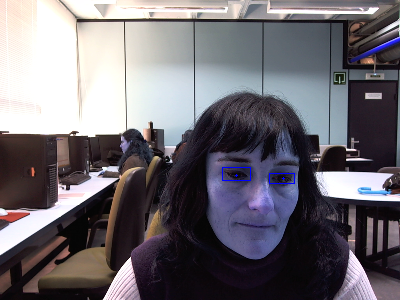

In [ ]:
a = show_box(train_matrix[96], train_labels[96])

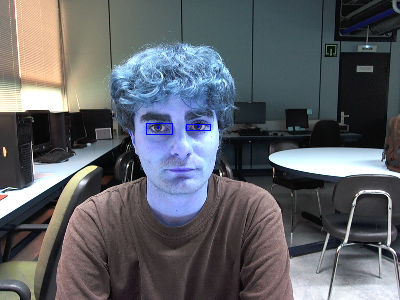

In [ ]:
a = show_box(validation_matrix[10], validation_labels[10])

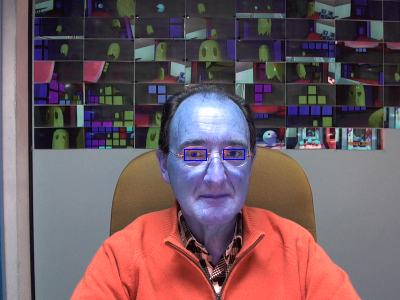

In [ ]:
a = show_box(test_matrix[10], test_labels[10])

### **Loading Dataset MPIIFaceGaze_Short**

#### **Getting Paths**

In [ ]:
main_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short"

In [ ]:
img_path = main_path + "/p02/day01/0016.jpg"
img = img_to_array(load_img(img_path))

In [ ]:
img.shape

(720, 1280, 3)

In [ ]:
all_paths = []
for i in range(15):
  if i < 10:
    person = f"/p0{i}"
  else:
    person = f"/p{i}"

  for j in range(7):
    day = f"/day0{j+1}"
    paths = []
    for k in os.listdir(main_path + person + day):
      img_path = os.path.join(main_path + person + day, k)
      paths.append(img_path)
    paths.sort()
    # all_paths.append(paths)
    for l in range(len(paths)):
      print(f"[{l}] - {paths[l]}")
      all_paths.append(paths[l])
    print()
  print("________________________________________________")
  # break

In [ ]:
for i in range(len(all_paths)):
  print(f"[{i}] - {all_paths[i]}")

#### **Loading Images**

In [ ]:
imgs_matrix = []
for i in range(len(all_paths)):
  # print(all_paths[i])
  imgs_matrix.append(img_to_array(load_img(all_paths[i], target_size = (360, 640))))

In [ ]:
imgs_matrix = np.array(imgs_matrix)
imgs_matrix.shape

(1038, 360, 640, 3)

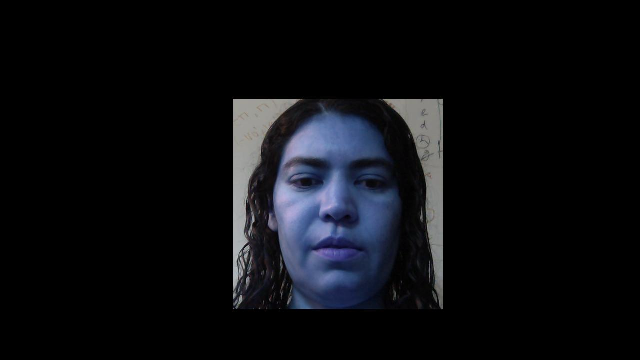

In [ ]:
cv2_imshow(imgs_matrix[0])

In [ ]:
# imgs_matrix = np.empty((1236,300,400,3))
# images_folder = main_path + "/images"

# for i in range(103):
#   if i < 9: person = f"/00{i+1}"
#   elif i < 99: person = f"/0{i+1}"
#   else: person = f"/{i+1}"

#   for j in range(12):
#     if j < 9: img = f"_0{j+1}"
#     else: img = f"_{j+1}"

#     img_path = main_path + "/images" + person + img + ".png"
#     # print(f"[{i*12 + j}] - {img_path}")
#     imgs_matrix[i*12 + j] = img_to_array(load_img(img_path, target_size = (300, 400)))

#### **Cleaning and Loading Truth Labels**

In [ ]:
truth_labels = []
for i in range(15):
  if i < 10:
    person = f"/p0{i}"
  else:
    person = f"/p{i}"

  label_path = main_path + person + person + ".txt"
  print(label_path)
  labels_file = open(label_path, "r")

  count = 0
  day = "day01"
  day_count = 1
  while(True):
    line = labels_file.readline()
    if line == "":
      labels_file.close()
      print("all lines read")
      break
    else:
      if("day08" in line):
        break

      if (day in line):
        ""
      else:
        day_count = day_count+1
        day = f"day0{day_count}"
        print("day:", day)
        count = 0

      if(count < 10):
        temp = line.replace(" ", ",")
        temp = temp.split(",")
        print(f"[{count}] - {temp}")
        temp = temp[1:15]
        temp = np.array(temp).astype("float32")*1/2
        temp = temp.astype(int)
        truth_labels.append(temp)
        count = count + 1
      else:
        continue
  print("__________________________________________________________")
  # break


In [ ]:
for i in range(len(truth_labels)):
  print(f"[{i}] - {truth_labels[i]}")

In [ ]:
truth_labels = np.array(truth_labels)

#### **Splitting Dataset**

In [ ]:
print(imgs_matrix.shape)
print(np.array(all_paths).shape)

(1038, 360, 640, 3)
(1038,)


In [ ]:
# indexes = np.arange(0, 1038)
# np.random.shuffle(indexes)
# print(indexes)
# print(indexes.shape)

In [ ]:
# train_indexes = indexes[:830]
# validation_indexes = indexes[830:934]
# test_indexes = indexes[934:]

In [ ]:
# len(train_indexes) + len(validation_indexes) + len(test_indexes)

In [ ]:
# train_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/train_indexes.txt"
# np.savetxt(train_indexes_path, np.array(train_indexes), fmt='%d')

# test_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/test_indexes.txt"
# np.savetxt(test_indexes_path, np.array(test_indexes), fmt='%d')

# validation_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/validation_indexes.txt"
# np.savetxt(validation_indexes_path, np.array(validation_indexes), fmt='%d')

In [ ]:
train_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/train_indexes.txt"
test_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/test_indexes.txt"
validation_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/validation_indexes.txt"

In [ ]:
train_indexes = np.loadtxt(train_indexes_path, dtype = 'int')
test_indexes = np.loadtxt(test_indexes_path, dtype = 'int')
validation_indexes = np.loadtxt(validation_indexes_path, dtype = 'int')

In [ ]:
print(train_indexes.shape)
print(test_indexes.shape)
print(validation_indexes.shape)

(830,)
(104,)
(104,)


In [ ]:
np.intersect1d(validation_indexes, test_indexes)

array([], dtype=int64)

In [ ]:
train_matrix = imgs_matrix[train_indexes]
train_labels = truth_labels[train_indexes].astype("float32")

validation_matrix = imgs_matrix[validation_indexes]
validation_labels = truth_labels[validation_indexes].astype("float32")

test_matrix = imgs_matrix[test_indexes]
test_labels = truth_labels[test_indexes].astype("float32")

In [ ]:
del imgs_matrix

In [ ]:
print(train_matrix.shape)
print(train_labels.shape)
print()
print(validation_matrix.shape)
print(validation_labels.shape)
print()
print(test_matrix.shape)
print(test_labels.shape)

print()
print(f"Total: {train_matrix.shape[0] + validation_matrix.shape[0] + test_matrix.shape[0]}")

(830, 360, 640, 3)
(830, 14)

(104, 360, 640, 3)
(104, 14)

(104, 360, 640, 3)
(104, 14)

Total: 1038


In [ ]:
train_labels.dtype

dtype('float32')

### **Testing Dataset**

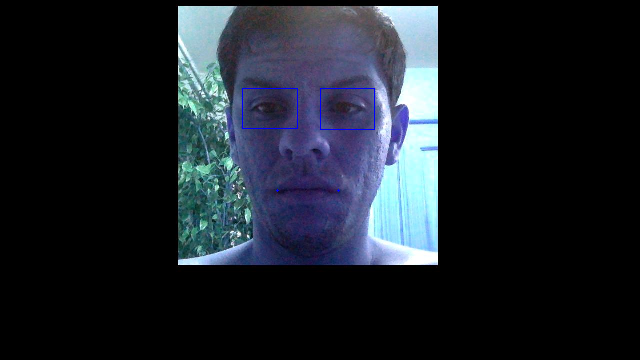

In [ ]:
a = show_box_MPII(train_matrix[96], train_labels[96])

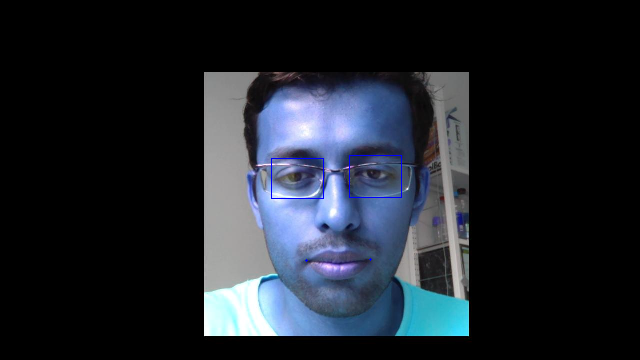

In [ ]:
a = show_box_MPII(validation_matrix[10], validation_labels[10])

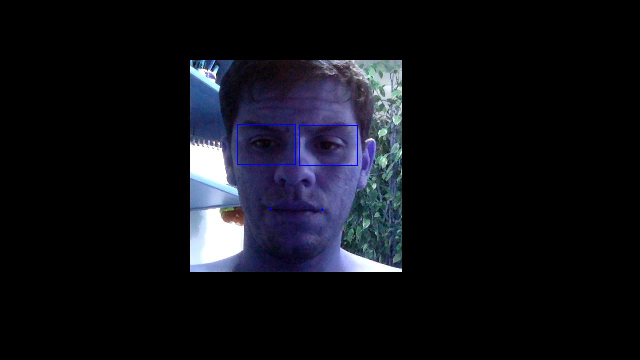

In [ ]:
a = show_box_MPII(test_matrix[10], test_labels[10])

### **Loading Dataset MPIIFaceGaze_Full**

#### **Getting Paths**

In [ ]:
main_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze"

In [ ]:
img_path = main_path + "/p02/day01/0016.jpg"
img = img_to_array(load_img(img_path))

In [ ]:
img.shape

(720, 1280, 3)

In [ ]:
all_paths = []
for i in range(15):
  if i < 10:
    person = f"/p0{i}"
  else:
    person = f"/p{i}"

  for j in range(7):
    day = f"/day0{j+1}"
    paths = []
    num = 0
    for k in os.listdir(main_path + person + day):
      if num == 15:
        break
      else:
        num = num + 1
        img_path = os.path.join(main_path + person + day, k)
        paths.append(img_path)
    paths.sort()
    for l in range(len(paths)):
      print(f"[{l}] - {paths[l]}")
      all_paths.append(paths[l])
    print()
  print("________________________________________________")
  # break

In [ ]:
for i in range(len(all_paths)):
  print(f"[{i}] - {all_paths[i]}")

#### **Loading Images**

In [ ]:
imgs_matrix = []
for i in range(len(all_paths)):
  # print(all_paths[i])
  imgs_matrix.append(img_to_array(load_img(all_paths[i], target_size = (360, 640))))

In [ ]:
imgs_matrix = np.array(imgs_matrix)
imgs_matrix.shape

(1530, 360, 640, 3)

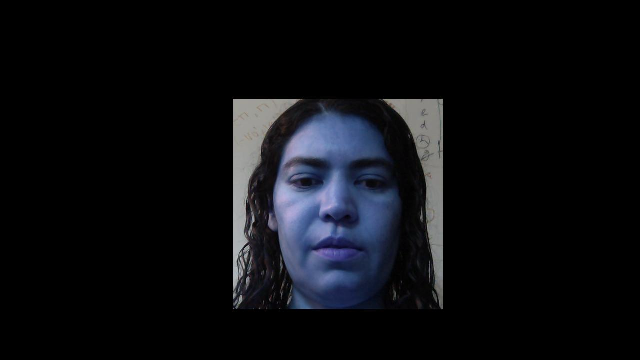

In [ ]:
cv2_imshow(imgs_matrix[0])

In [ ]:
# imgs_matrix = np.empty((1236,300,400,3))
# images_folder = main_path + "/images"

# for i in range(103):
#   if i < 9: person = f"/00{i+1}"
#   elif i < 99: person = f"/0{i+1}"
#   else: person = f"/{i+1}"

#   for j in range(12):
#     if j < 9: img = f"_0{j+1}"
#     else: img = f"_{j+1}"

#     img_path = main_path + "/images" + person + img + ".png"
#     # print(f"[{i*12 + j}] - {img_path}")
#     imgs_matrix[i*12 + j] = img_to_array(load_img(img_path, target_size = (300, 400)))

#### **Cleaning and Loading Truth Labels**

In [ ]:
truth_labels = []
for i in range(15):
  if i < 10:
    person = f"/p0{i}"
  else:
    person = f"/p{i}"

  label_path = main_path + person + person + ".txt"
  print(label_path)
  labels_file = open(label_path, "r")

  count = 0
  day = "day01"
  day_count = 1
  while(True):
    line = labels_file.readline()
    if line == "":
      labels_file.close()
      print("all lines read")
      break
    else:
      if("day08" in line):
        break

      if (day in line):
        ""
      else:
        day_count = day_count+1
        day = f"day0{day_count}"
        print("day:", day)
        count = 0

      if(count < 15):
        temp = line.replace(" ", ",")
        temp = temp.split(",")
        print(f"[{count}] - {temp}")
        temp = temp[1:15]
        temp = np.array(temp).astype("float32")*1/2
        temp = temp.astype(int)
        truth_labels.append(temp)
        count = count + 1
      else:
        continue
  print("__________________________________________________________")
  # break


In [ ]:
for i in range(len(truth_labels)):
  print(f"[{i}] - {truth_labels[i]}")

In [ ]:
truth_labels = np.array(truth_labels)

#### **Splitting Dataset**

In [ ]:
print(imgs_matrix.shape)
print(np.array(all_paths).shape)

(1530, 360, 640, 3)
(1530,)


In [ ]:
# indexes = np.arange(0, 1530)
# np.random.shuffle(indexes)
# print(indexes)
# print(indexes.shape)

In [ ]:
# train_indexes = indexes[:1224]
# validation_indexes = indexes[1224:1377]
# test_indexes = indexes[1377:]

In [ ]:
# len(train_indexes) + len(validation_indexes) + len(test_indexes)

In [ ]:
# train_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/train_indexes.txt"
# np.savetxt(train_indexes_path, np.array(train_indexes), fmt='%d')

# test_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/test_indexes.txt"
# np.savetxt(test_indexes_path, np.array(test_indexes), fmt='%d')

# validation_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/validation_indexes.txt"
# np.savetxt(validation_indexes_path, np.array(validation_indexes), fmt='%d')

In [ ]:
train_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/train_indexes.txt"
test_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/test_indexes.txt"
validation_indexes_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/validation_indexes.txt"

In [ ]:
train_indexes = np.loadtxt(train_indexes_path, dtype = 'int')
test_indexes = np.loadtxt(test_indexes_path, dtype = 'int')
validation_indexes = np.loadtxt(validation_indexes_path, dtype = 'int')

In [ ]:
print(train_indexes.shape)
print(test_indexes.shape)
print(validation_indexes.shape)

(1224,)
(153,)
(153,)


In [ ]:
np.intersect1d(validation_indexes, test_indexes)

array([], dtype=int64)

In [ ]:
train_matrix = imgs_matrix[train_indexes]
train_labels = truth_labels[train_indexes].astype("float32")

validation_matrix = imgs_matrix[validation_indexes]
validation_labels = truth_labels[validation_indexes].astype("float32")

test_matrix = imgs_matrix[test_indexes]
test_labels = truth_labels[test_indexes].astype("float32")

In [ ]:
del imgs_matrix

In [ ]:
print(train_matrix.shape)
print(train_labels.shape)
print()
print(validation_matrix.shape)
print(validation_labels.shape)
print()
print(test_matrix.shape)
print(test_labels.shape)

print()
print(f"Total: {train_matrix.shape[0] + validation_matrix.shape[0] + test_matrix.shape[0]}")

(1224, 360, 640, 3)
(1224, 14)

(153, 360, 640, 3)
(153, 14)

(153, 360, 640, 3)
(153, 14)

Total: 1530


In [ ]:
train_labels.dtype

dtype('float32')

### **Testing Dataset**

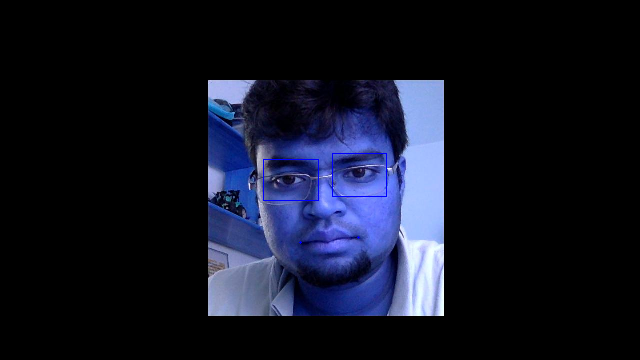

In [ ]:
a = show_box_MPII(train_matrix[96], train_labels[96])

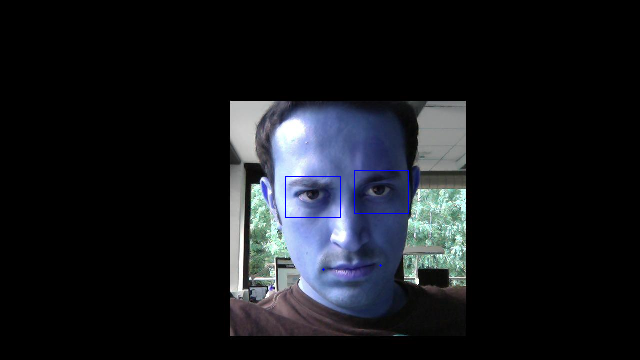

In [ ]:
a = show_box_MPII(validation_matrix[10], validation_labels[10])

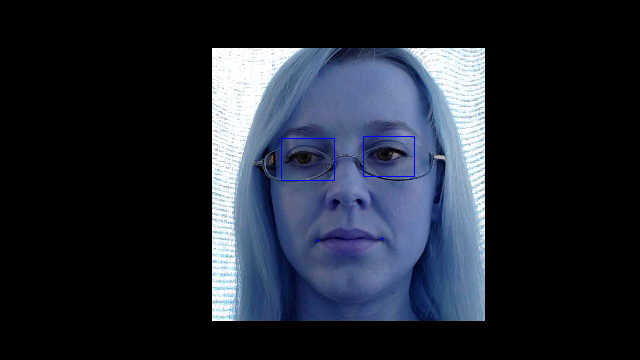

In [ ]:
a = show_box_MPII(test_matrix[10], test_labels[10])

### **Model_iter_1**

In [ ]:
# input  = Input((300, 400,3), name = "Input_Layer")
input  = Input((360, 640, 3), name = "Input_Layer")
x = Rescaling(scale = 1./255)(input)

#Block_1
x = Conv2D(32, (3,3), (1,1), "same", name = "B1_C1")(x)
x = BatchNormalization(name = "B1_BN1")(x)
x1 = Activation("relu", name = "B1_R1")(x)

x = Conv2D(64, (3,3), (1,1),"valid", name = "B1_C2")(x1)
x = BatchNormalization(name = "B1_BN2")(x)
x = Activation("relu", name = "B1_R2")(x)

x = Conv2D(32, (1,1), (2,2), "same", name = "B1_C3")(x)
x = BatchNormalization(name = "B1_BN3")(x)
x = Activation("relu", name = "B1_R3")(x)

x2 = Conv2D(32, (3,3), (2,2),"valid", name = "B1_C4_skip")(x1)
x2 = BatchNormalization(name = "B1_BN4")(x2)
x2 = Activation("relu", name = "B1_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B1_Add")



#Block_2
x = Conv2D(64, (3,3), (1,1), "same", name = "B2_C1")(x)
x = BatchNormalization(name = "B2_BN1")(x)
x1 = Activation("relu", name = "B2_R1")(x)

x = Conv2D(128, (3,3), (1,1),"valid", name = "B2_C2")(x1)
x = BatchNormalization(name = "B2_BN2")(x)
x = Activation("relu", name = "B2_R2")(x)

x = Conv2D(64, (1,1), (2,2), "same", name = "B2_C3")(x)
x = BatchNormalization(name = "B2_BN3")(x)
x = Activation("relu", name = "B2_R3")(x)

x2 = Conv2D(64, (3,3), (2,2),"valid", name = "B2_C4_skip")(x1)
x2 = BatchNormalization(name = "B2_BN4")(x2)
x2 = Activation("relu", name = "B2_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B2_Add")
x = MaxPooling2D((3,3), (2,2), name = "MP_1")(x)



#Block_3
x = Conv2D(128, (3,3), (1,1), "same", name = "B3_C1")(x)
x = BatchNormalization(name = "B3_BN1")(x)
x1 = Activation("relu", name = "B3_R1")(x)

x = Conv2D(256, (3,3), (1,1),"valid", name = "B3_C2")(x1)
x = BatchNormalization(name = "B3_BN2")(x)
x = Activation("relu", name = "B3_R2")(x)

x = Conv2D(256, (1,1), (2,2), "same", name = "B3_C3")(x)
x = BatchNormalization(name = "B3_BN3")(x)
x = Activation("relu", name = "B3_R3")(x)

x2 = Conv2D(256, (3,3), (2,2),"valid", name = "B3_C4_skip")(x1)
x2 = BatchNormalization(name = "B3_BN4")(x2)
x2 = Activation("relu", name = "B3_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B3_Add")



#Block_4
x = Conv2D(256, (3,3), (1,1), "same", name = "B4_C1")(x)
x = BatchNormalization(name = "B4_BN1")(x)
x1 = Activation("relu", name = "B4_R1")(x)

x = Conv2D(512, (3,3), (1,1),"valid", name = "B4_C2")(x1)
x = BatchNormalization(name = "B4_BN2")(x)
x = Activation("relu", name = "B4_R2")(x)

x = Conv2D(512, (1,1), (2,2), "same", name = "B4_C3")(x)
x = BatchNormalization(name = "B4_BN3")(x)
x = Activation("relu", name = "B4_R3")(x)

x2 = Conv2D(512, (3,3), (2,2),"valid", name = "B4_C4_skip")(x1)
x2 = BatchNormalization(name = "B4_BN4")(x2)
x2 = Activation("relu", name = "B4_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B4_Add")
x = MaxPooling2D((3,3), (2,2), name = "MP_2")(x)

#FCL
x = Flatten(name = "Flatten")(x)
# x = Dense(512, "relu", name = "D1")(x)
# x = Dense(512, "relu", name = "D2")(x)
output = Dense(14, "relu", name = "D3_Output")(x)

model = Model(inputs = input, outputs = output)

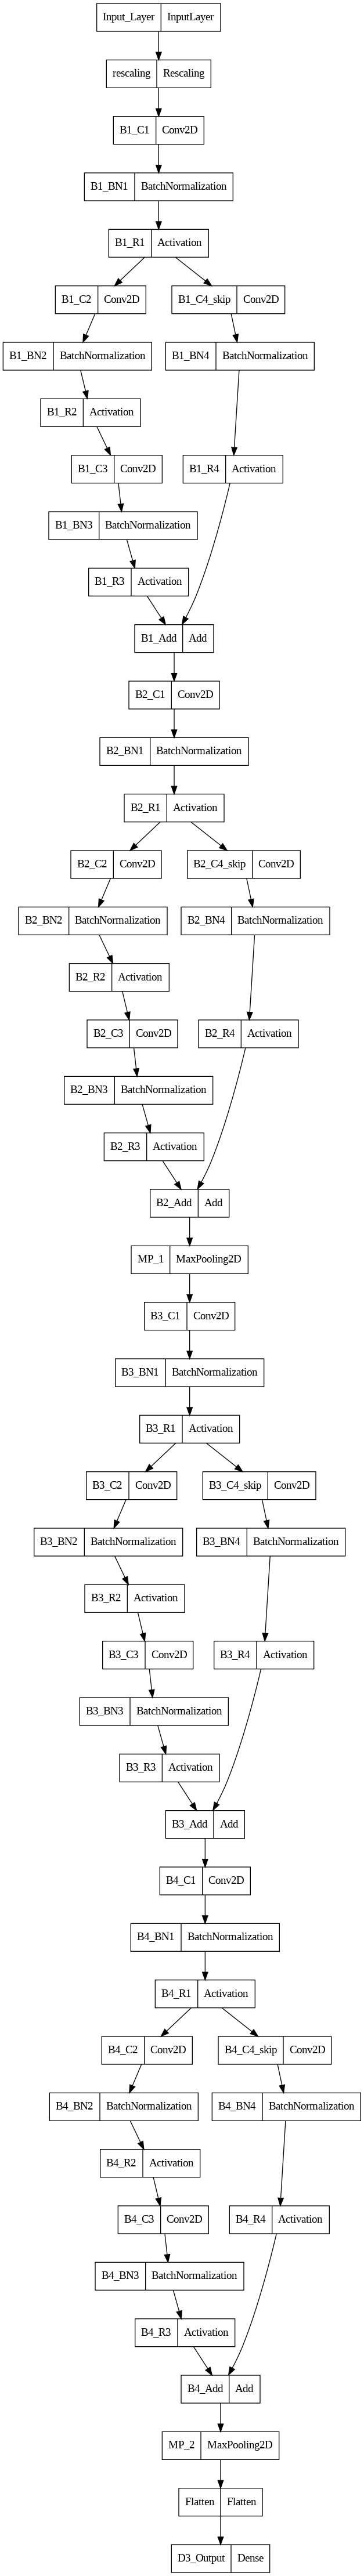

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# import visualkeras
# visualkeras.layered_view(model, spacing=10, legend=True, type_ignore=[BatchNormalization, Activation, Rescaling])

In [ ]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.00001),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
# model.summary()

In [ ]:
# inputs = Rescaling(scale = 1./255)(train_matrix)

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 80, batch_size = 16)

Epoch 1/80
52/52 [==============================] - 88s 1s/step - loss: 78281.4297 - r2_score: -66.3399 - val_loss: 81879.9062 - val_r2_score: -92.0746
Epoch 2/80
52/52 [==============================] - 33s 636ms/step - loss: 67029.7812 - r2_score: -56.5458 - val_loss: 80763.8281 - val_r2_score: -90.7984
Epoch 3/80
52/52 [==============================] - 33s 637ms/step - loss: 55641.1953 - r2_score: -46.5331 - val_loss: 78603.3906 - val_r2_score: -88.3237
Epoch 4/80
52/52 [==============================] - 33s 638ms/step - loss: 44638.4258 - r2_score: -36.7389 - val_loss: 72233.7969 - val_r2_score: -80.9387
Epoch 5/80
52/52 [==============================] - 33s 641ms/step - loss: 34832.4062 - r2_score: -27.9133 - val_loss: 62017.3828 - val_r2_score: -68.9873
Epoch 6/80
52/52 [==============================] - 33s 642ms/step - loss: 26744.7969 - r2_score: -20.5252 - val_loss: 51576.4414 - val_r2_score: -56.6489
Epoch 7/80
52/52 [==============================] - 34s 646ms/step - loss

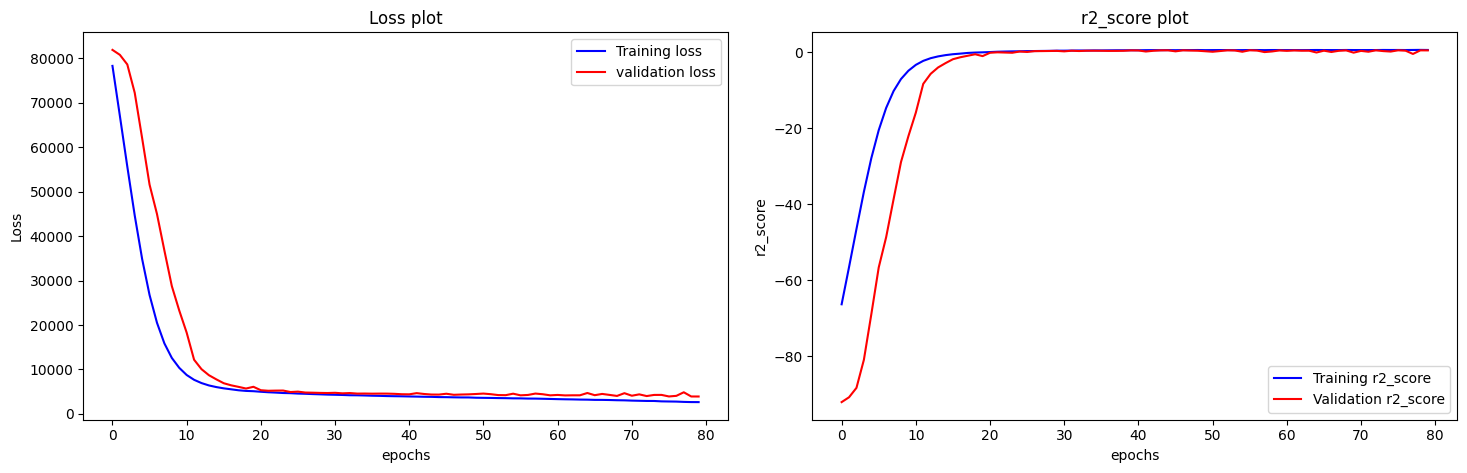

In [ ]:
acc_loss_plot(history)

In [ ]:
#saving the weights of the model
weights_path = "/content/drive/MyDrive/GI4E_Dataset/Model_weights/weights_custom_model.h5"
model.save_weights(weights_path)
# model.load_weights(weights_path)

In [ ]:
weights_path = "/content/drive/MyDrive/GI4E_Dataset/Model_weights/weights_custom_model.h5"
model.load_weights(weights_path)

In [ ]:
model.evaluate(test_matrix, test_labels)

4/4 [==============================] - 14s 244ms/step - loss: 4192.5459 - r2_score: 0.3736


[4192.5458984375, 0.37360507249832153]

In [ ]:
pred = model.predict(tf.expand_dims(test_matrix[10], axis = 0))

In [ ]:
pred.astype(int)

In [ ]:
show_box(test_matrix[10], pred[0].astype(int))

### **Model_iter_2**

In [ ]:
# input  = Input((300, 400,3), name = "Input_Layer")
input  = Input((360, 640, 3), name = "Input_Layer")
x = Rescaling(scale = 1./255)(input)

#Block_1
x = Conv2D(32, (3,3), (1,1), "same", name = "B1_C1")(x)
x = BatchNormalization(name = "B1_BN1")(x)
x1 = Activation("relu", name = "B1_R1")(x)

x = Conv2D(64, (3,3), (1,1),"valid", name = "B1_C2")(x1)
x = BatchNormalization(name = "B1_BN2")(x)
x = Activation("relu", name = "B1_R2")(x)

x = Conv2D(32, (1,1), (2,2), "same", name = "B1_C3")(x)
x = BatchNormalization(name = "B1_BN3")(x)
x = Activation("relu", name = "B1_R3")(x)

x2 = Conv2D(32, (3,3), (2,2),"valid", name = "B1_C4_skip")(x1)
x2 = BatchNormalization(name = "B1_BN4")(x2)
x2 = Activation("relu", name = "B1_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B1_Add")



#Block_2
x = Conv2D(64, (3,3), (1,1), "same", name = "B2_C1")(x)
x = BatchNormalization(name = "B2_BN1")(x)
x1 = Activation("relu", name = "B2_R1")(x)

x = Conv2D(128, (3,3), (1,1),"valid", name = "B2_C2")(x1)
x = BatchNormalization(name = "B2_BN2")(x)
x = Activation("relu", name = "B2_R2")(x)

x = Conv2D(64, (1,1), (2,2), "same", name = "B2_C3")(x)
x = BatchNormalization(name = "B2_BN3")(x)
x = Activation("relu", name = "B2_R3")(x)

x2 = Conv2D(64, (3,3), (2,2),"valid", name = "B2_C4_skip")(x1)
x2 = BatchNormalization(name = "B2_BN4")(x2)
x2 = Activation("relu", name = "B2_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B2_Add")
x = MaxPooling2D((3,3), (2,2), name = "MP_1")(x)



#Block_3
x = Conv2D(128, (3,3), (1,1), "same", name = "B3_C1")(x)
x = BatchNormalization(name = "B3_BN1")(x)
x1 = Activation("relu", name = "B3_R1")(x)

x = Conv2D(256, (3,3), (1,1),"valid", name = "B3_C2")(x1)
x = BatchNormalization(name = "B3_BN2")(x)
x = Activation("relu", name = "B3_R2")(x)

x = Conv2D(256, (1,1), (2,2), "same", name = "B3_C3")(x)
x = BatchNormalization(name = "B3_BN3")(x)
x = Activation("relu", name = "B3_R3")(x)

x2 = Conv2D(256, (3,3), (2,2),"valid", name = "B3_C4_skip")(x1)
x2 = BatchNormalization(name = "B3_BN4")(x2)
x2 = Activation("relu", name = "B3_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B3_Add")



# #Block_4
# x = Conv2D(256, (3,3), (1,1), "same", name = "B4_C1")(x)
# x = BatchNormalization(name = "B4_BN1")(x)
# x1 = Activation("relu", name = "B4_R1")(x)

# x = Conv2D(512, (3,3), (1,1),"valid", name = "B4_C2")(x1)
# x = BatchNormalization(name = "B4_BN2")(x)
# x = Activation("relu", name = "B4_R2")(x)

# x = Conv2D(512, (1,1), (2,2), "same", name = "B4_C3")(x)
# x = BatchNormalization(name = "B4_BN3")(x)
# x = Activation("relu", name = "B4_R3")(x)

# x2 = Conv2D(512, (3,3), (2,2),"valid", name = "B4_C4_skip")(x1)
# x2 = BatchNormalization(name = "B4_BN4")(x2)
# x2 = Activation("relu", name = "B4_R4")(x2)

# x = tf.keras.layers.add([x2,x], name = "B4_Add")
x = MaxPooling2D((3,3), (2,2), name = "MP_2")(x)

#FCL
x = Flatten(name = "Flatten")(x)
# x = Dense(512, "relu", name = "D1")(x)
# x = Dense(512, "relu", name = "D2")(x)
output = Dense(14, "relu", name = "D3_Output")(x)

model = Model(inputs = input, outputs = output)

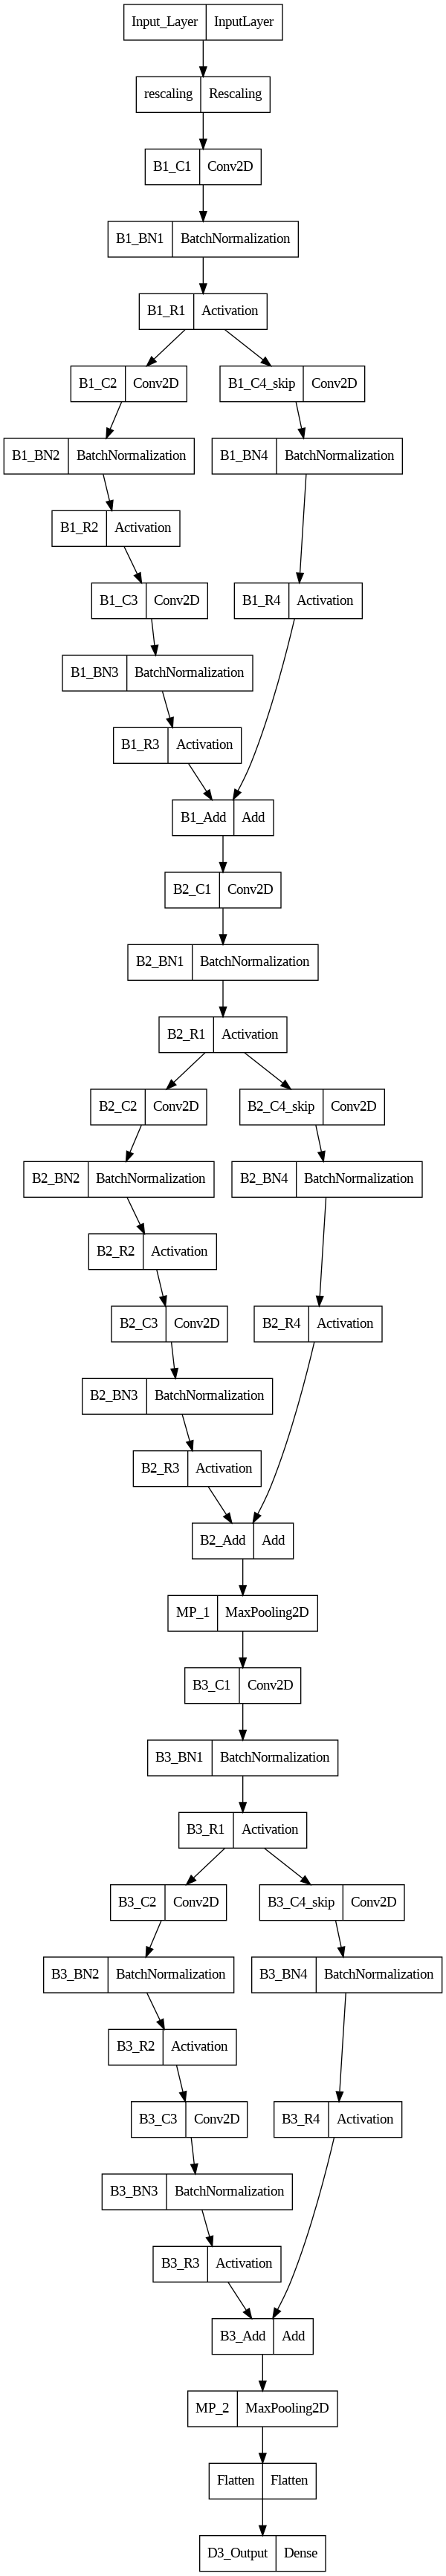

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 360, 640, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 360, 640, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 B1_C1 (Conv2D)              (None, 360, 640, 32)         896       ['rescaling[0][0]']           
                                                                                                  
 B1_BN1 (BatchNormalization  (None, 360, 640, 32)         128       ['B1_C1[0][0]']               
 )                                                                                            

In [ ]:
# inputs = Rescaling(scale = 1./255)(train_matrix)

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 20, batch_size = 16)

Epoch 1/20
52/52 [==============================] - 84s 1s/step - loss: 8942.7725 - r2_score: -3.2071 - val_loss: 30478.8867 - val_r2_score: -30.0274
Epoch 2/20
52/52 [==============================] - 32s 617ms/step - loss: 4387.3765 - r2_score: 0.7058 - val_loss: 15258.8525 - val_r2_score: -10.2975
Epoch 3/20
52/52 [==============================] - 33s 626ms/step - loss: 4372.2617 - r2_score: 0.7642 - val_loss: 13894.0615 - val_r2_score: -8.8761
Epoch 4/20
52/52 [==============================] - 33s 628ms/step - loss: 4234.7095 - r2_score: 0.7764 - val_loss: 10475.9482 - val_r2_score: -5.4880
Epoch 5/20
52/52 [==============================] - 32s 624ms/step - loss: 4140.3101 - r2_score: 0.7919 - val_loss: 8395.0869 - val_r2_score: -3.0726
Epoch 6/20
52/52 [==============================] - 32s 621ms/step - loss: 4006.7058 - r2_score: 0.7800 - val_loss: 7275.9775 - val_r2_score: -1.3557
Epoch 7/20
52/52 [==============================] - 32s 624ms/step - loss: 4082.2878 - r2_score:

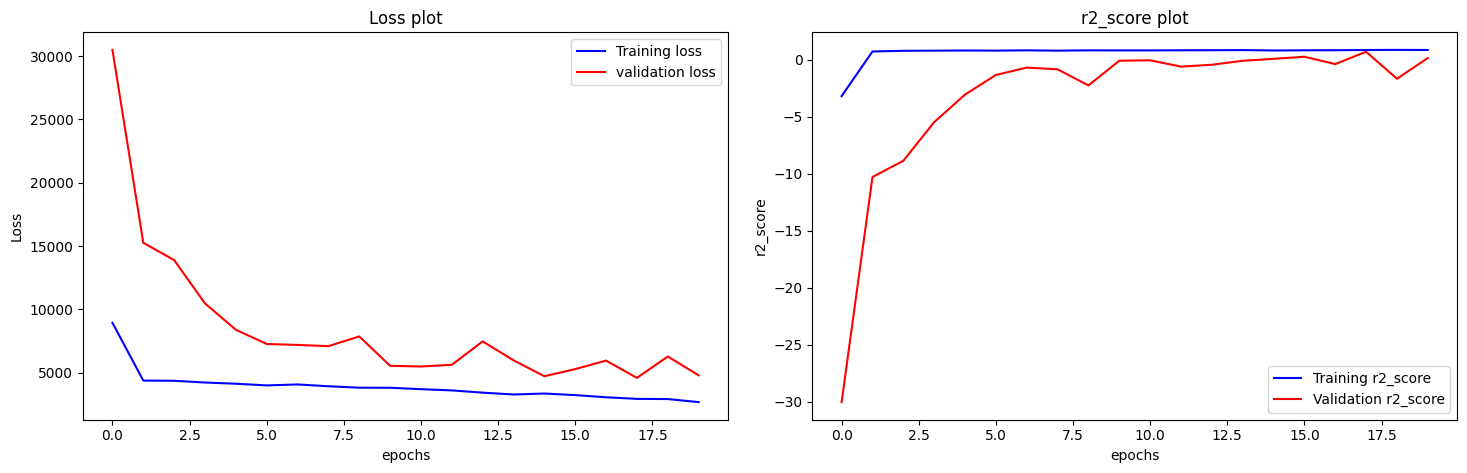

In [ ]:
acc_loss_plot(history)

In [ ]:
model.evaluate(test_matrix, test_labels)

4/4 [==============================] - 13s 248ms/step - loss: 5038.1230 - r2_score: 0.2930


[5038.123046875, 0.29299718141555786]

### **Model_iter_3**

In [ ]:
# input  = Input((300, 400,3), name = "Input_Layer")
input  = Input((360, 640, 3), name = "Input_Layer")
x = Rescaling(scale = 1./255)(input)

#Block_1
x = Conv2D(32, (3,3), (1,1), "same", name = "B1_C1")(x)
x = BatchNormalization(name = "B1_BN1")(x)
x1 = Activation("relu", name = "B1_R1")(x)

x = Conv2D(16, (3,3), (1,1),"valid", name = "B1_C2")(x1)
x = BatchNormalization(name = "B1_BN2")(x)
x = Activation("relu", name = "B1_R2")(x)

x = Conv2D(32, (1,1), (2,2), "same", name = "B1_C3")(x)
x = BatchNormalization(name = "B1_BN3")(x)
x = Activation("relu", name = "B1_R3")(x)

x2 = Conv2D(32, (3,3), (2,2),"valid", name = "B1_C4_skip")(x1)
x2 = BatchNormalization(name = "B1_BN4")(x2)
x2 = Activation("relu", name = "B1_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B1_Add")


#Block_2
x = Conv2D(64, (3,3), (1,1), "same", name = "B2_C1")(x)
x = BatchNormalization(name = "B2_BN1")(x)
x1 = Activation("relu", name = "B2_R1")(x)

x = Conv2D(32, (3,3), (1,1),"valid", name = "B2_C2")(x1)
x = BatchNormalization(name = "B2_BN2")(x)
x = Activation("relu", name = "B2_R2")(x)

x = Conv2D(64, (1,1), (2,2), "same", name = "B2_C3")(x)
x = BatchNormalization(name = "B2_BN3")(x)
x = Activation("relu", name = "B2_R3")(x)

x2 = Conv2D(64, (3,3), (2,2),"valid", name = "B2_C4_skip")(x1)
x2 = BatchNormalization(name = "B2_BN4")(x2)
x2 = Activation("relu", name = "B2_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B2_Add")
# x = MaxPooling2D((3,3), (2,2), name = "MP_1")(x)


#Block_3
x = Conv2D(128, (3,3), (1,1), "same", name = "B3_C1")(x)
x = BatchNormalization(name = "B3_BN1")(x)
x1 = Activation("relu", name = "B3_R1")(x)

x = Conv2D(64, (3,3), (1,1),"valid", name = "B3_C2")(x1)
x = BatchNormalization(name = "B3_BN2")(x)
x = Activation("relu", name = "B3_R2")(x)

x = Conv2D(128, (1,1), (2,2), "same", name = "B3_C3")(x)
x = BatchNormalization(name = "B3_BN3")(x)
x = Activation("relu", name = "B3_R3")(x)

x2 = Conv2D(128, (3,3), (2,2),"valid", name = "B3_C4_skip")(x1)
x2 = BatchNormalization(name = "B3_BN4")(x2)
x2 = Activation("relu", name = "B3_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B3_Add")


#Block_4
x = Conv2D(256, (3,3), (1,1), "same", name = "B4_C1")(x)
x = BatchNormalization(name = "B4_BN1")(x)
x1 = Activation("relu", name = "B4_R1")(x)

x = Conv2D(128, (3,3), (1,1),"valid", name = "B4_C2")(x1)
x = BatchNormalization(name = "B4_BN2")(x)
x = Activation("relu", name = "B4_R2")(x)

x = Conv2D(256, (1,1), (2,2), "same", name = "B4_C3")(x)
x = BatchNormalization(name = "B4_BN3")(x)
x = Activation("relu", name = "B4_R3")(x)

x2 = Conv2D(256, (3,3), (2,2),"valid", name = "B4_C4_skip")(x1)
x2 = BatchNormalization(name = "B4_BN4")(x2)
x2 = Activation("relu", name = "B4_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B4_Add")
# x = MaxPooling2D((3,3), (2,2), name = "MP_2")(x)

#FCL
x = Flatten(name = "Flatten")(x)
# x = Dense(512, "relu", name = "D1")(x)
# x = Dense(512, "relu", name = "D2")(x)
output = Dense(14, "relu", name = "D3_Output")(x)

model = Model(inputs = input, outputs = output)

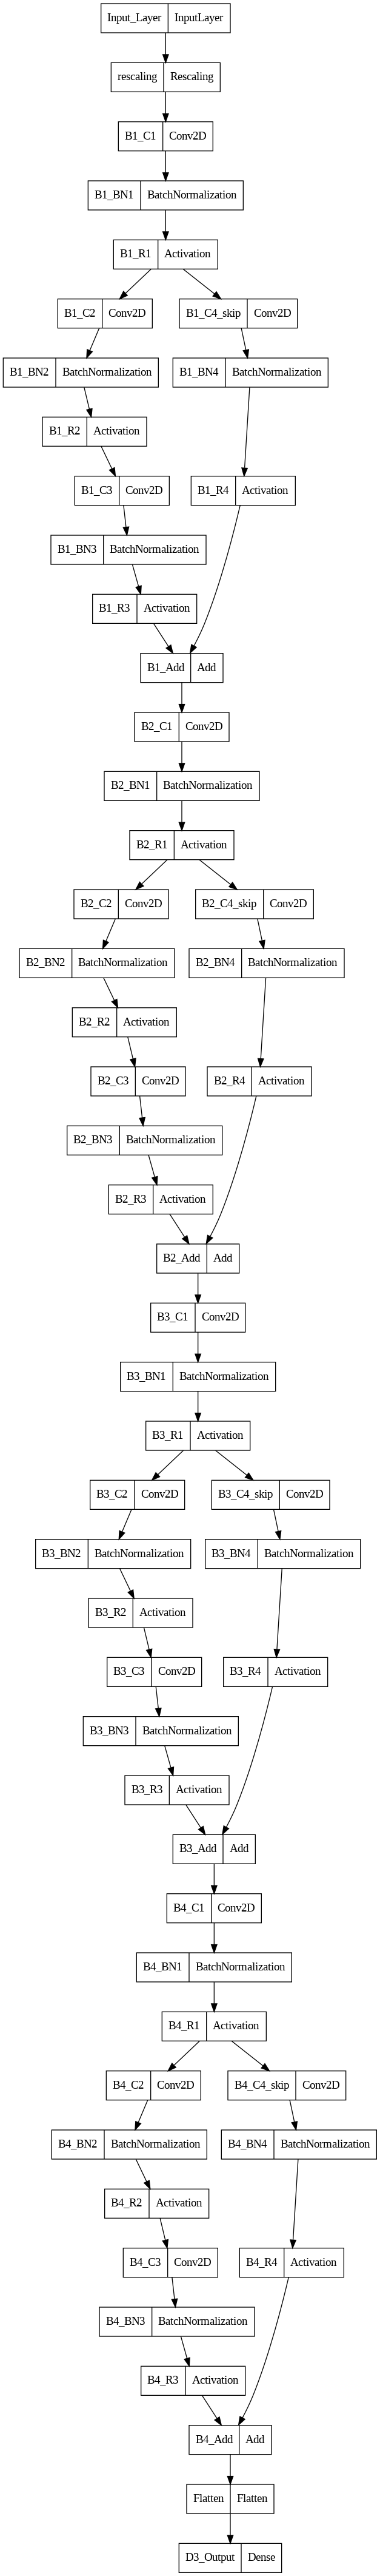

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 360, 640, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 360, 640, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 B1_C1 (Conv2D)              (None, 360, 640, 32)         896       ['rescaling[0][0]']           
                                                                                                  
 B1_BN1 (BatchNormalization  (None, 360, 640, 32)         128       ['B1_C1[0][0]']               
 )                                                                                            

In [ ]:
# inputs = Rescaling(scale = 1./255)(train_matrix)

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 20, batch_size = 16)

Epoch 1/20
52/52 [==============================] - 79s 918ms/step - loss: 8061.2993 - r2_score: -2.3451 - val_loss: 41834.2422 - val_r2_score: -43.2136
Epoch 2/20
52/52 [==============================] - 26s 503ms/step - loss: 4383.3560 - r2_score: 0.6028 - val_loss: 22130.3926 - val_r2_score: -19.1865
Epoch 3/20
52/52 [==============================] - 26s 503ms/step - loss: 4174.4775 - r2_score: 0.6609 - val_loss: 12667.4688 - val_r2_score: -8.4872
Epoch 4/20
52/52 [==============================] - 27s 516ms/step - loss: 3901.7793 - r2_score: 0.7147 - val_loss: 9133.3652 - val_r2_score: -3.5431
Epoch 5/20
52/52 [==============================] - 27s 522ms/step - loss: 3875.6304 - r2_score: 0.7206 - val_loss: 7152.5576 - val_r2_score: -1.7447
Epoch 6/20
52/52 [==============================] - 27s 516ms/step - loss: 3779.1394 - r2_score: 0.6789 - val_loss: 6326.4380 - val_r2_score: -0.6453
Epoch 7/20
52/52 [==============================] - 27s 523ms/step - loss: 3562.2993 - r2_scor

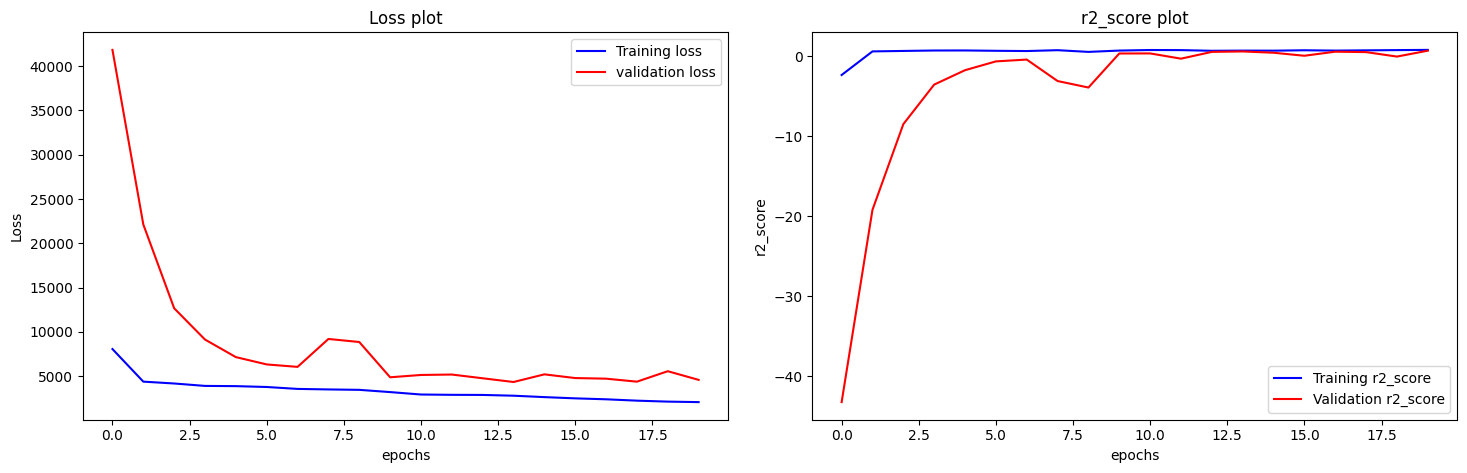

In [ ]:
acc_loss_plot(history)

In [ ]:
# model.evaluate(test_matrix, test_labels)

### **Model_iter_4**

In [ ]:
# input  = Input((300, 400,3), name = "Input_Layer")
input  = Input((360, 640, 3), name = "Input_Layer")
x = Rescaling(scale = 1./255)(input)

#Block_1
x = Conv2D(32, (3,3), (1,1), "same", name = "B1_C1")(x)
x = BatchNormalization(name = "B1_BN1")(x)
x1 = Activation("relu", name = "B1_R1")(x)

x = Conv2D(16, (5,5), (1,1),"valid", name = "B1_C2")(x1)
x = BatchNormalization(name = "B1_BN2")(x)
x = Activation("relu", name = "B1_R2")(x)

x = Conv2D(32, (3,3), (2,2), "same", name = "B1_C3")(x)
x = BatchNormalization(name = "B1_BN3")(x)
x = Activation("relu", name = "B1_R3")(x)

x2 = Conv2D(32, (5,5), (2,2),"valid", name = "B1_C4_skip")(x1)
x2 = BatchNormalization(name = "B1_BN4")(x2)
x2 = Activation("relu", name = "B1_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B1_Add")


#Block_2
x = Conv2D(64, (3,3), (1,1), "same", name = "B2_C1")(x)
x = BatchNormalization(name = "B2_BN1")(x)
x1 = Activation("relu", name = "B2_R1")(x)

x = Conv2D(32, (5,5), (1,1),"valid", name = "B2_C2")(x1)
x = BatchNormalization(name = "B2_BN2")(x)
x = Activation("relu", name = "B2_R2")(x)

x = Conv2D(64, (3,3), (2,2), "same", name = "B2_C3")(x)
x = BatchNormalization(name = "B2_BN3")(x)
x = Activation("relu", name = "B2_R3")(x)

x2 = Conv2D(64, (5,5), (2,2),"valid", name = "B2_C4_skip")(x1)
x2 = BatchNormalization(name = "B2_BN4")(x2)
x2 = Activation("relu", name = "B2_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B2_Add")
# x = MaxPooling2D((3,3), (2,2), name = "MP_1")(x)


#Block_3
x = Conv2D(128, (3,3), (1,1), "same", name = "B3_C1")(x)
x = BatchNormalization(name = "B3_BN1")(x)
x1 = Activation("relu", name = "B3_R1")(x)

x = Conv2D(64, (5,5), (1,1),"valid", name = "B3_C2")(x1)
x = BatchNormalization(name = "B3_BN2")(x)
x = Activation("relu", name = "B3_R2")(x)

x = Conv2D(128, (3,3), (2,2), "same", name = "B3_C3")(x)
x = BatchNormalization(name = "B3_BN3")(x)
x = Activation("relu", name = "B3_R3")(x)

x2 = Conv2D(128, (5,5), (2,2),"valid", name = "B3_C4_skip")(x1)
x2 = BatchNormalization(name = "B3_BN4")(x2)
x2 = Activation("relu", name = "B3_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B3_Add")


#Block_4
x = Conv2D(256, (3,3), (1,1), "same", name = "B4_C1")(x)
x = BatchNormalization(name = "B4_BN1")(x)
x1 = Activation("relu", name = "B4_R1")(x)

x = Conv2D(128, (5,5), (1,1),"valid", name = "B4_C2")(x1)
x = BatchNormalization(name = "B4_BN2")(x)
x = Activation("relu", name = "B4_R2")(x)

x = Conv2D(256, (3,3), (2,2), "same", name = "B4_C3")(x)
x = BatchNormalization(name = "B4_BN3")(x)
x = Activation("relu", name = "B4_R3")(x)

x2 = Conv2D(256, (5,5), (2,2),"valid", name = "B4_C4_skip")(x1)
x2 = BatchNormalization(name = "B4_BN4")(x2)
x2 = Activation("relu", name = "B4_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B4_Add")
# x = MaxPooling2D((3,3), (2,2), name = "MP_2")(x)

#FCL
x = Flatten(name = "Flatten")(x)
# x = Dense(512, "relu", name = "D1")(x)
# x = Dense(512, "relu", name = "D2")(x)
output = Dense(14, "relu", name = "D3_Output")(x)

model = Model(inputs = input, outputs = output)

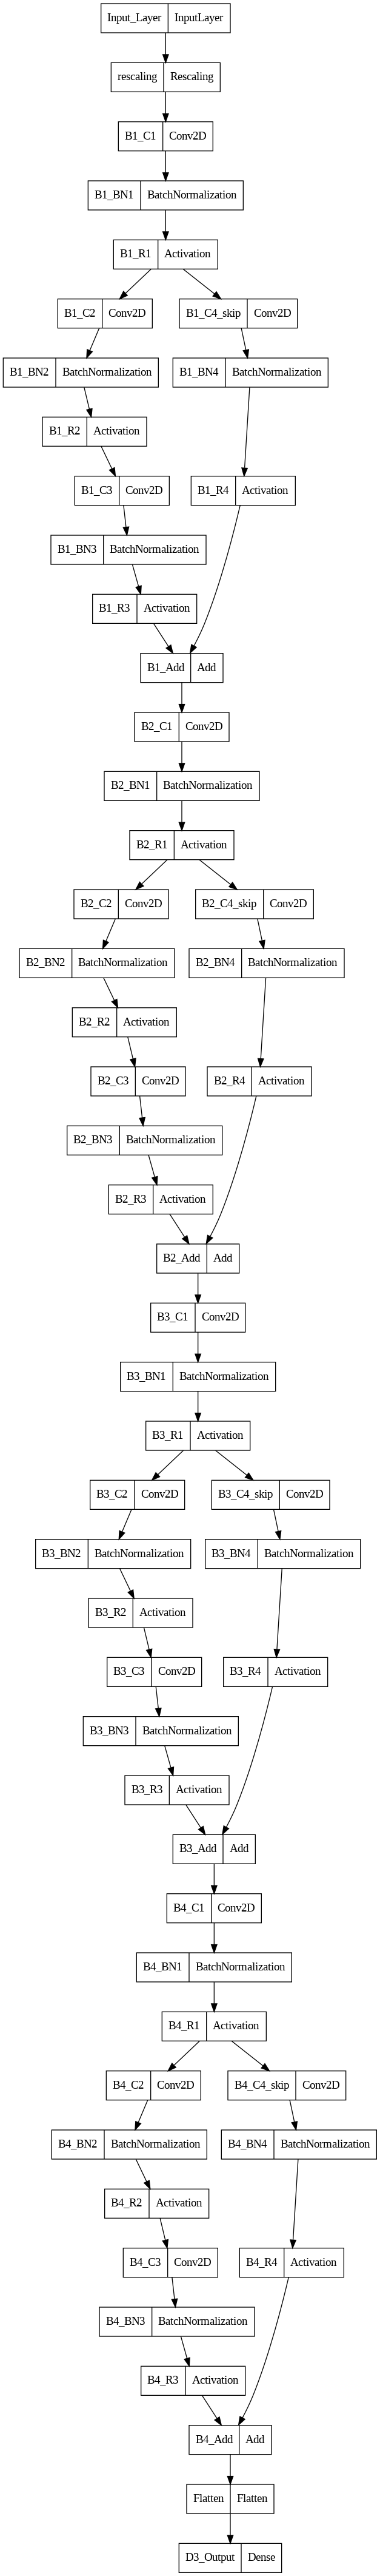

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 360, 640, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 360, 640, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 B1_C1 (Conv2D)              (None, 360, 640, 32)         896       ['rescaling[0][0]']           
                                                                                                  
 B1_BN1 (BatchNormalization  (None, 360, 640, 32)         128       ['B1_C1[0][0]']               
 )                                                                                            

In [ ]:
# inputs = Rescaling(scale = 1./255)(train_matrix)

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 20, batch_size = 16)

Epoch 1/20
52/52 [==============================] - 116s 1s/step - loss: 8562.2539 - r2_score: -2.7249 - val_loss: 18588.2148 - val_r2_score: -15.0822
Epoch 2/20
52/52 [==============================] - 35s 679ms/step - loss: 4448.9297 - r2_score: 0.6452 - val_loss: 11921.7705 - val_r2_score: -8.0851
Epoch 3/20
52/52 [==============================] - 36s 684ms/step - loss: 4298.2515 - r2_score: 0.6608 - val_loss: 6517.3428 - val_r2_score: -0.9324
Epoch 4/20
52/52 [==============================] - 36s 691ms/step - loss: 4124.9282 - r2_score: 0.7221 - val_loss: 7451.7197 - val_r2_score: -0.7264
Epoch 5/20
52/52 [==============================] - 36s 690ms/step - loss: 3932.5747 - r2_score: 0.7457 - val_loss: 12286.6309 - val_r2_score: -6.8567
Epoch 6/20
52/52 [==============================] - 36s 689ms/step - loss: 3922.4456 - r2_score: 0.7456 - val_loss: 10090.7979 - val_r2_score: -5.0978
Epoch 7/20
52/52 [==============================] - 36s 691ms/step - loss: 3689.9880 - r2_score:

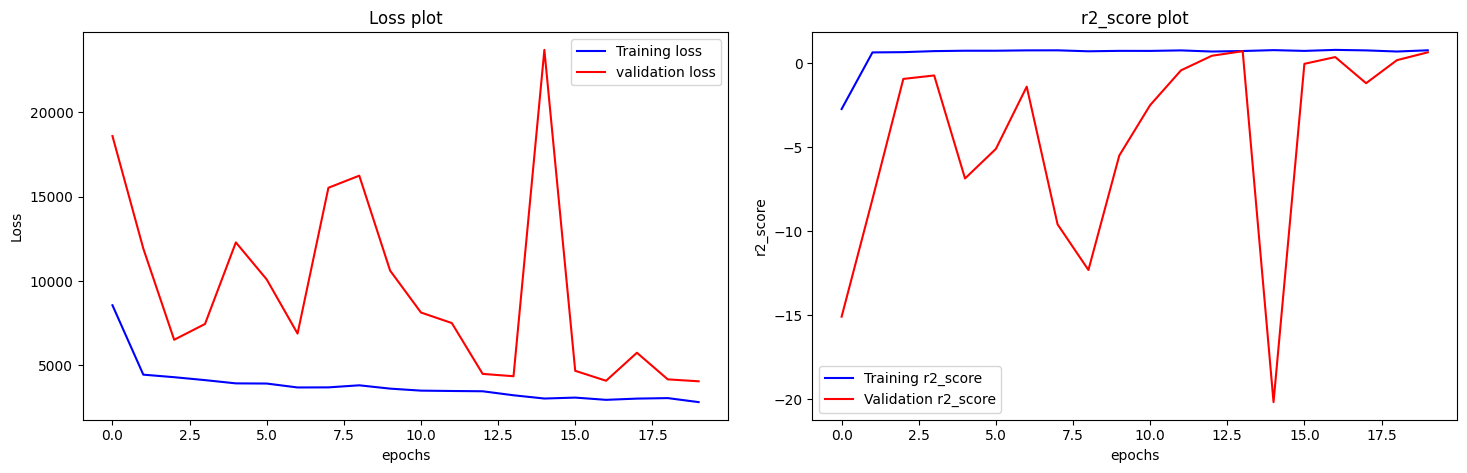

In [ ]:
acc_loss_plot(history)

In [ ]:
model.evaluate(test_matrix, test_labels)

4/4 [==============================] - 19s 263ms/step - loss: 4064.9155 - r2_score: 0.6611


[4064.91552734375, 0.6611207127571106]

### **Model_iter_5**

In [ ]:
# input  = Input((300, 400,3), name = "Input_Layer")
input  = Input((360, 640, 3), name = "Input_Layer")
x = Rescaling(scale = 1./255)(input)

#Block_1
x = Conv2D(64, (3,3), (1,1), "same", name = "B1_C1")(x)
x = BatchNormalization(name = "B1_BN1")(x)
x1 = Activation("relu", name = "B1_R1")(x)

x = Conv2D(32, (3,3), (1,1),"same", name = "B1_C2")(x1)
x = BatchNormalization(name = "B1_BN2")(x)
x = Activation("relu", name = "B1_R2")(x)

x = Conv2D(16, (3,3), (2,2), "same", name = "B1_C3")(x)
x = BatchNormalization(name = "B1_BN3")(x)
x = Activation("relu", name = "B1_R3")(x)

x2 = Conv2D(32, (5,5), (2,2),"same", name = "B1_C4_skip")(x1)
x2 = BatchNormalization(name = "B1_BN4")(x2)
x2 = Activation("relu", name = "B1_R4")(x2)

x = tf.keras.layers.Concatenate(axis = -1)([x2,x])


#Block_2
x = Conv2D(128, (3,3), (1,1), "same", name = "B2_C1")(x)
x = BatchNormalization(name = "B2_BN1")(x)
x1 = Activation("relu", name = "B2_R1")(x)

x = Conv2D(64, (5,5), (1,1),"valid", name = "B2_C2")(x1)
x = BatchNormalization(name = "B2_BN2")(x)
x = Activation("relu", name = "B2_R2")(x)

x = Conv2D(32, (3,3), (2,2), "same", name = "B2_C3")(x)
x = BatchNormalization(name = "B2_BN3")(x)
x = Activation("relu", name = "B2_R3")(x)

x2 = Conv2D(64, (5,5), (2,2),"valid", name = "B2_C4_skip")(x1)
x2 = BatchNormalization(name = "B2_BN4")(x2)
x2 = Activation("relu", name = "B2_R4")(x2)

x = tf.keras.layers.Concatenate(axis = -1)([x2,x])
# x = MaxPooling2D((3,3), (2,2), name = "MP_1")(x)


#Block_3
x = Conv2D(256, (3,3), (1,1), "same", name = "B3_C1")(x)
x = BatchNormalization(name = "B3_BN1")(x)
x1 = Activation("relu", name = "B3_R1")(x)

x = Conv2D(128, (5,5), (1,1),"valid", name = "B3_C2")(x1)
x = BatchNormalization(name = "B3_BN2")(x)
x = Activation("relu", name = "B3_R2")(x)

x = Conv2D(64, (3,3), (2,2), "same", name = "B3_C3")(x)
x = BatchNormalization(name = "B3_BN3")(x)
x = Activation("relu", name = "B3_R3")(x)

x2 = Conv2D(128, (5,5), (2,2),"valid", name = "B3_C4_skip")(x1)
x2 = BatchNormalization(name = "B3_BN4")(x2)
x2 = Activation("relu", name = "B3_R4")(x2)

x = tf.keras.layers.Concatenate(axis = -1)([x2,x])


#Block_4
x = Conv2D(512, (3,3), (1,1), "same", name = "B4_C1")(x)
x = BatchNormalization(name = "B4_BN1")(x)
x1 = Activation("relu", name = "B4_R1")(x)

x = Conv2D(256, (5,5), (1,1),"valid", name = "B4_C2")(x1)
x = BatchNormalization(name = "B4_BN2")(x)
x = Activation("relu", name = "B4_R2")(x)

x = Conv2D(128, (3,3), (2,2), "same", name = "B4_C3")(x)
x = BatchNormalization(name = "B4_BN3")(x)
x = Activation("relu", name = "B4_R3")(x)

x2 = Conv2D(256, (5,5), (2,2),"valid", name = "B4_C4_skip")(x1)
x2 = BatchNormalization(name = "B4_BN4")(x2)
x2 = Activation("relu", name = "B4_R4")(x2)

x = tf.keras.layers.Concatenate(axis = -1)([x2,x])
# x = MaxPooling2D((3,3), (2,2), name = "MP_2")(x)

#FCL
x = Flatten(name = "Flatten")(x)
# x = Dense(512, "relu", name = "D1")(x)
# x = Dense(512, "relu", name = "D2")(x)
output = Dense(14, "relu", name = "D3_Output")(x)

model = Model(inputs = input, outputs = output)

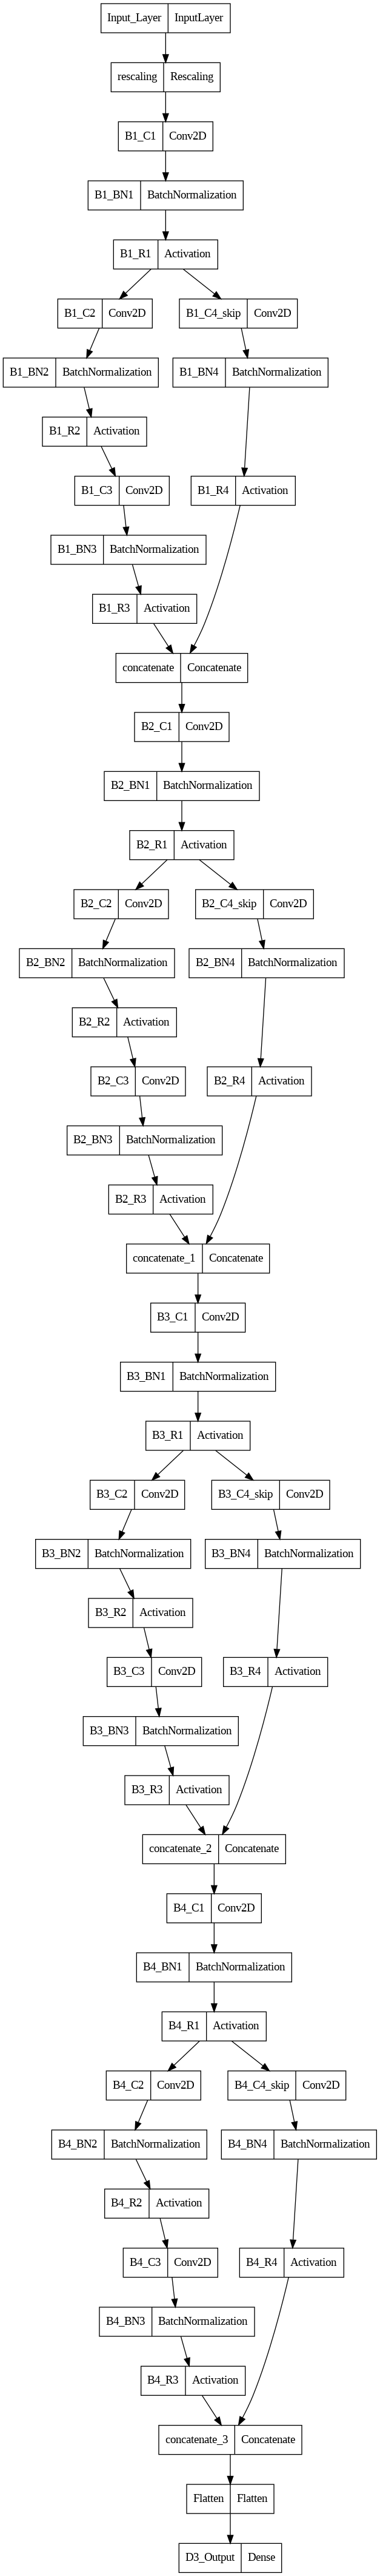

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 360, 640, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 360, 640, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 B1_C1 (Conv2D)              (None, 360, 640, 64)         1792      ['rescaling[0][0]']           
                                                                                                  
 B1_BN1 (BatchNormalization  (None, 360, 640, 64)         256       ['B1_C1[0][0]']               
 )                                                                                            

In [ ]:
# inputs = Rescaling(scale = 1./255)(train_matrix)

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 20, batch_size = 16)

Epoch 1/20
52/52 [==============================] - 184s 2s/step - loss: 8684.2129 - r2_score: -3.1089 - val_loss: 66010.5312 - val_r2_score: -71.2777
Epoch 2/20
52/52 [==============================] - 68s 1s/step - loss: 4404.5103 - r2_score: 0.6851 - val_loss: 6258.7300 - val_r2_score: -0.4951
Epoch 3/20
52/52 [==============================] - 68s 1s/step - loss: 4275.2451 - r2_score: 0.7289 - val_loss: 5916.2710 - val_r2_score: -0.3749
Epoch 4/20
52/52 [==============================] - 69s 1s/step - loss: 4007.2576 - r2_score: 0.7321 - val_loss: 5402.4717 - val_r2_score: -0.0655
Epoch 5/20
52/52 [==============================] - 69s 1s/step - loss: 3970.6897 - r2_score: 0.6852 - val_loss: 7532.3291 - val_r2_score: -2.2182
Epoch 6/20
52/52 [==============================] - 68s 1s/step - loss: 3970.3245 - r2_score: 0.6420 - val_loss: 6608.0630 - val_r2_score: -0.6802
Epoch 7/20
52/52 [==============================] - 69s 1s/step - loss: 3761.0227 - r2_score: 0.7434 - val_loss: 8

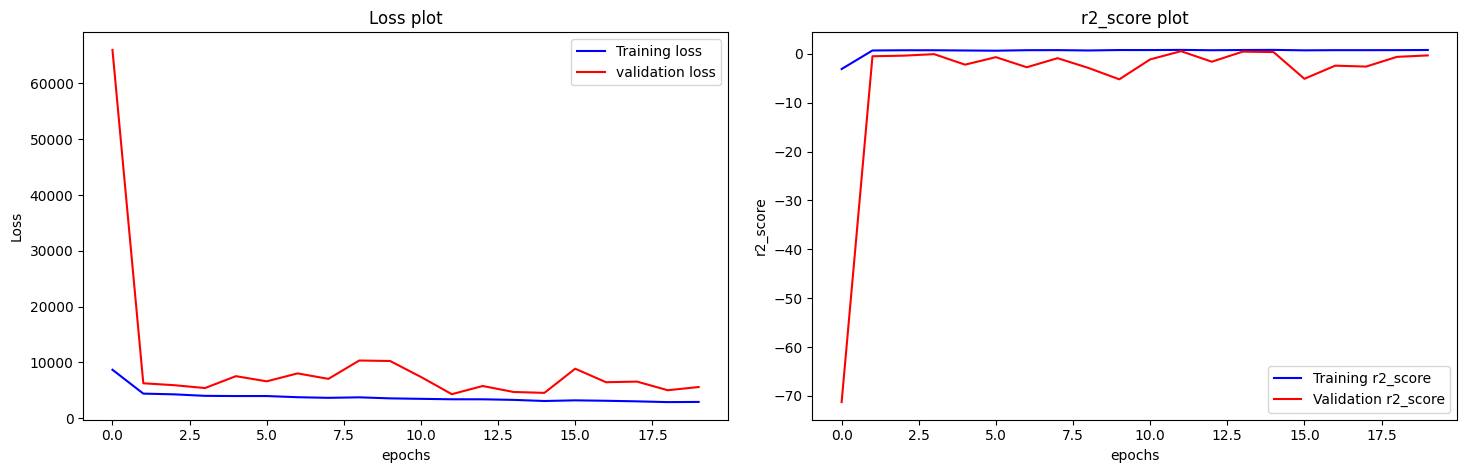

In [ ]:
acc_loss_plot(history)

In [ ]:
model.evaluate(test_matrix, test_labels)

4/4 [==============================] - 35s 505ms/step - loss: 7070.4580 - r2_score: -0.0438


[7070.4580078125, -0.0438404344022274]

### **Model_iter_6**

In [ ]:
# input  = Input((300, 400,3), name = "Input_Layer")
input  = Input((360, 640, 3), name = "Input_Layer")
x = Rescaling(scale = 1./255)(input)

#Block_1
x = Conv2D(64, (3,3), (1,1), "same", name = "B1_C1")(x)
x = BatchNormalization(name = "B1_BN1")(x)
x1 = Activation("relu", name = "B1_R1")(x)

x = Conv2D(32, (3,3), (1,1),"same", name = "B1_C2")(x1)
x = BatchNormalization(name = "B1_BN2")(x)
x = Activation("relu", name = "B1_R2")(x)

x = Conv2D(16, (3,3), (2,2), "same", name = "B1_C3")(x)
x = BatchNormalization(name = "B1_BN3")(x)
x = Activation("relu", name = "B1_R3")(x)

x2 = Conv2D(32, (5,5), (2,2),"same", name = "B1_C4_skip")(x1)
x2 = BatchNormalization(name = "B1_BN4")(x2)
x2 = Activation("relu", name = "B1_R4")(x2)

x = tf.keras.layers.Concatenate(axis = -1)([x2,x])


#Block_2
x = Conv2D(128, (3,3), (1,1), "same", name = "B2_C1")(x)
x = BatchNormalization(name = "B2_BN1")(x)
x1 = Activation("relu", name = "B2_R1")(x)

x = Conv2D(64, (5,5), (1,1),"valid", name = "B2_C2")(x1)
x = BatchNormalization(name = "B2_BN2")(x)
x = Activation("relu", name = "B2_R2")(x)

x = Conv2D(32, (3,3), (2,2), "same", name = "B2_C3")(x)
x = BatchNormalization(name = "B2_BN3")(x)
x = Activation("relu", name = "B2_R3")(x)

x2 = Conv2D(64, (5,5), (2,2),"valid", name = "B2_C4_skip")(x1)
x2 = BatchNormalization(name = "B2_BN4")(x2)
x2 = Activation("relu", name = "B2_R4")(x2)

x = tf.keras.layers.Concatenate(axis = -1)([x2,x])
# x = MaxPooling2D((3,3), (2,2), name = "MP_1")(x)


#Block_3
x = Conv2D(256, (3,3), (1,1), "same", name = "B3_C1")(x)
x = BatchNormalization(name = "B3_BN1")(x)
x1 = Activation("relu", name = "B3_R1")(x)

x = Conv2D(128, (5,5), (1,1),"valid", name = "B3_C2")(x1)
x = BatchNormalization(name = "B3_BN2")(x)
x = Activation("relu", name = "B3_R2")(x)

x = Conv2D(64, (3,3), (2,2), "same", name = "B3_C3")(x)
x = BatchNormalization(name = "B3_BN3")(x)
x = Activation("relu", name = "B3_R3")(x)

x2 = Conv2D(128, (5,5), (2,2),"valid", name = "B3_C4_skip")(x1)
x2 = BatchNormalization(name = "B3_BN4")(x2)
x2 = Activation("relu", name = "B3_R4")(x2)

x = tf.keras.layers.Concatenate(axis = -1)([x2,x])


#Block_4
x = Conv2D(512, (3,3), (1,1), "same", name = "B4_C1")(x)
x = BatchNormalization(name = "B4_BN1")(x)
x1 = Activation("relu", name = "B4_R1")(x)

x = Conv2D(256, (5,5), (1,1),"valid", name = "B4_C2")(x1)
x = BatchNormalization(name = "B4_BN2")(x)
x = Activation("relu", name = "B4_R2")(x)

x = Conv2D(128, (3,3), (2,2), "same", name = "B4_C3")(x)
x = BatchNormalization(name = "B4_BN3")(x)
x = Activation("relu", name = "B4_R3")(x)

x2 = Conv2D(256, (5,5), (2,2),"valid", name = "B4_C4_skip")(x1)
x2 = BatchNormalization(name = "B4_BN4")(x2)
x2 = Activation("relu", name = "B4_R4")(x2)

x = tf.keras.layers.Concatenate(axis = -1)([x2,x])
# x = MaxPooling2D((3,3), (2,2), name = "MP_2")(x)

#FCL
x = Flatten(name = "Flatten")(x)
x = Dense(512, "relu", name = "D1")(x)
# x = Dense(512, "relu", name = "D2")(x)
output = Dense(14, "relu", name = "D3_Output")(x)

model = Model(inputs = input, outputs = output)

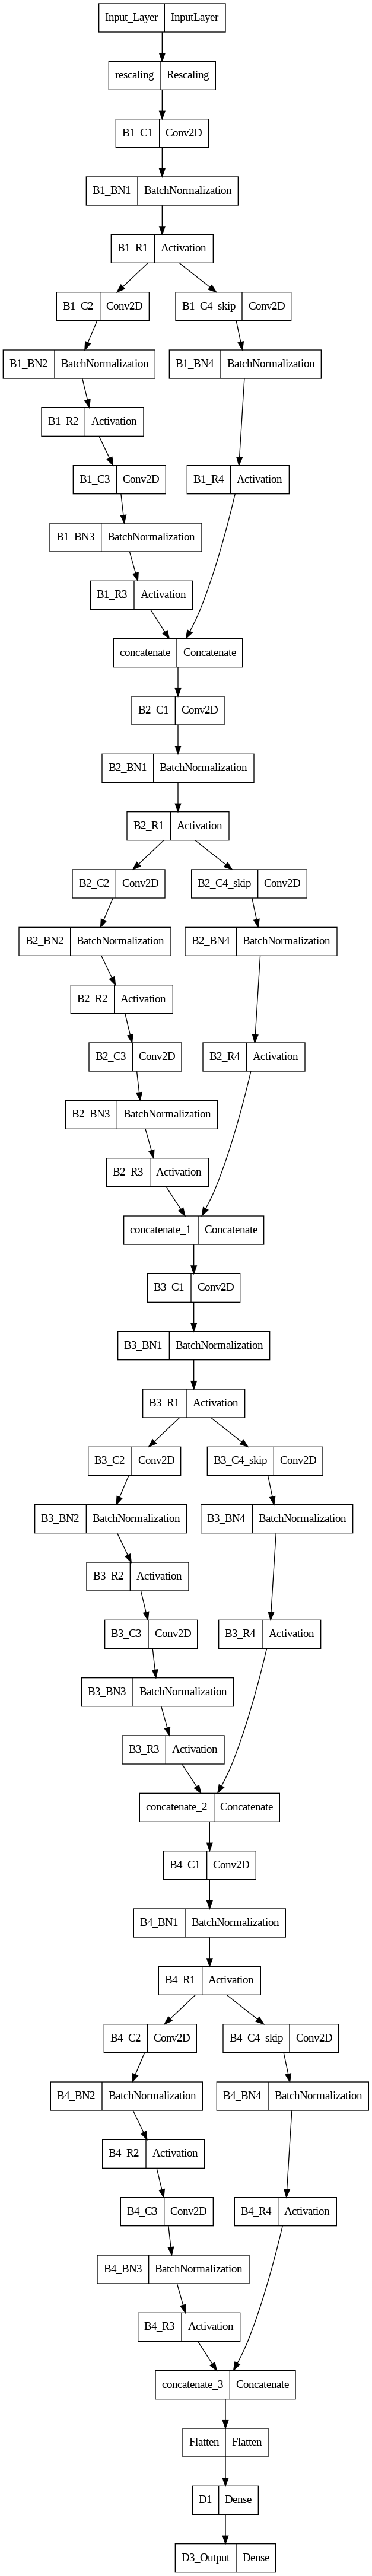

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = [tf.keras.metrics.R2Score(), tf.keras.metrics.MeanAbsoluteError()]
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 360, 640, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 360, 640, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 B1_C1 (Conv2D)              (None, 360, 640, 64)         1792      ['rescaling[0][0]']           
                                                                                                  
 B1_BN1 (BatchNormalization  (None, 360, 640, 64)         256       ['B1_C1[0][0]']               
 )                                                                                            

In [ ]:
# inputs = Rescaling(scale = 1./255)(train_matrix)

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 20, batch_size = 16)

Epoch 1/20
52/52 [==============================] - 187s 3s/step - loss: 9272.9629 - r2_score: -3.0827 - mean_absolute_error: 60.2933 - val_loss: 24932.1152 - val_r2_score: -21.6638 - val_mean_absolute_error: 137.9703
Epoch 2/20
52/52 [==============================] - 72s 1s/step - loss: 5333.8252 - r2_score: -0.0251 - mean_absolute_error: 43.0032 - val_loss: 19857.7344 - val_r2_score: -14.0017 - val_mean_absolute_error: 114.5799
Epoch 3/20
52/52 [==============================] - 72s 1s/step - loss: 4653.2041 - r2_score: 0.2897 - mean_absolute_error: 37.7144 - val_loss: 12492.2334 - val_r2_score: -7.9150 - val_mean_absolute_error: 84.5565
Epoch 4/20
52/52 [==============================] - 72s 1s/step - loss: 4676.6089 - r2_score: 0.3890 - mean_absolute_error: 36.4235 - val_loss: 13180.6416 - val_r2_score: -8.5310 - val_mean_absolute_error: 90.7380
Epoch 5/20
52/52 [==============================] - 71s 1s/step - loss: 4435.6514 - r2_score: 0.2303 - mean_absolute_error: 37.8972 - val

KeyboardInterrupt: ignored

In [ ]:
acc_loss_plot(history)

In [ ]:
model.evaluate(test_matrix, test_labels)

### **Model_iter_7**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
#network pruning model, he_distribution for weights initilization
input  = Input((360, 640, 3), name = "Input_Layer")

x = Conv2D(32, (3,3), (1,1), 'same', name = "Conv2D_1", kernel_initializer = tf.keras.initializers.he_uniform())(input)
x = MaxPooling2D((4,4), (2,2), name = "MaxPool_1")(x)
x = Activation('relu', name = "Relu_1")(x)
x = BatchNormalization(name = "BatchNorm_1")(x)

x = Conv2D(32*2, (3,3), (1,1), 'same', name = "Conv2D_2", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = MaxPooling2D((4,4), (2,2), name = "MaxPool_2")(x)
x = Activation('relu', name = "Relu_2")(x)
x = BatchNormalization(name = "BatchNorm_2")(x)

x = Conv2D(32*4, (3,3), (1,1), 'same', name = "Conv2D_3", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = MaxPooling2D((4,4), (2,2), name = "MaxPool_3")(x)
x = Activation('relu', name = "Relu_3")(x)
x = BatchNormalization(name = "BatchNorm_3")(x)

x = Conv2D(32*4, (3,3), (2,2), 'same', name = "Conv2D_4", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = MaxPooling2D((2,2), (2,2), name = "MaxPool_4")(x)
x = Activation('relu', name = "Relu_4")(x)
x = BatchNormalization(name = "BatchNorm_4")(x)

x = Flatten(name = "Flatten")(x)

output = Dense(14)(x)

model = Model(inputs = input, outputs = output)

In [ ]:
# tf.keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 360, 640, 3)]     0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 360, 640, 32)      896       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 179, 319, 32)      0         
                                                                 
 Relu_1 (Activation)         (None, 179, 319, 32)      0         
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 179, 319, 32)      128       
 ation)                                                          
                                                                 
 Conv2D_2 (Conv2D)           (None, 179, 319, 64)      18496     
                                                             

In [ ]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = [tf.keras.metrics.R2Score(), tf.keras.metrics.MeanAbsoluteError()]
)

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 20, batch_size = 32)

Epoch 1/20
26/26 [==============================] - 11s 309ms/step - loss: 30402.1992 - r2_score: -23.5146 - mean_absolute_error: 134.3857 - val_loss: 50849.2031 - val_r2_score: -54.7982 - val_mean_absolute_error: 158.2801
Epoch 2/20
26/26 [==============================] - 7s 272ms/step - loss: 6501.0562 - r2_score: -1.2131 - mean_absolute_error: 51.6072 - val_loss: 18341.9512 - val_r2_score: -15.4041 - val_mean_absolute_error: 91.0076
Epoch 3/20
26/26 [==============================] - 7s 269ms/step - loss: 5304.8994 - r2_score: -0.1928 - mean_absolute_error: 41.5794 - val_loss: 19098.8984 - val_r2_score: -17.2820 - val_mean_absolute_error: 119.5690
Epoch 4/20
26/26 [==============================] - 7s 271ms/step - loss: 4863.4912 - r2_score: 0.1510 - mean_absolute_error: 36.5867 - val_loss: 12166.1074 - val_r2_score: -9.1206 - val_mean_absolute_error: 91.0412
Epoch 5/20
26/26 [==============================] - 7s 274ms/step - loss: 4611.5107 - r2_score: 0.3236 - mean_absolute_error

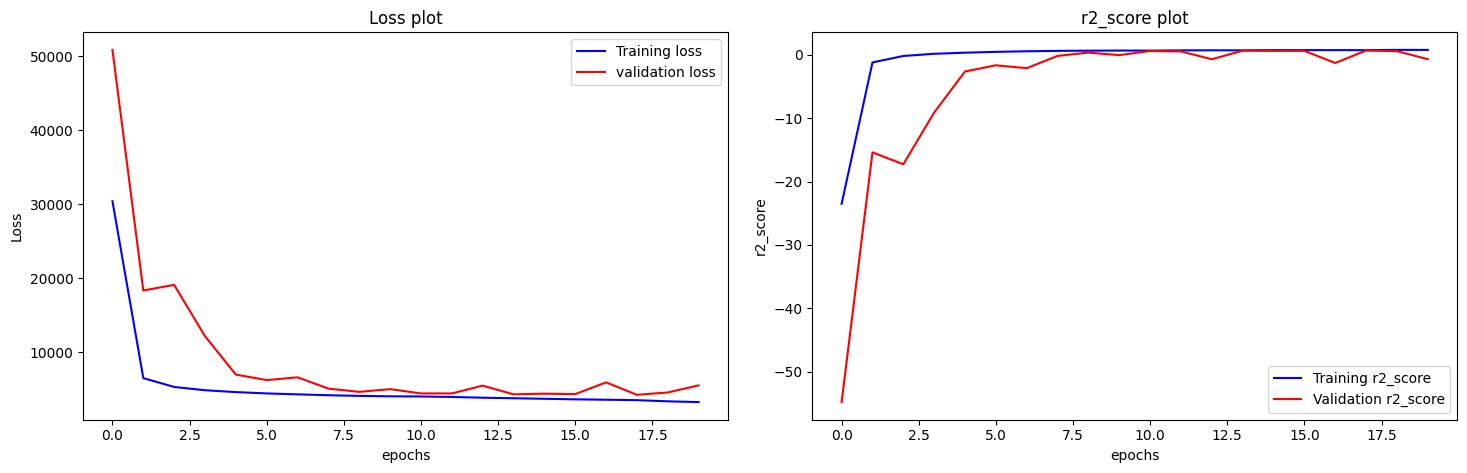

In [ ]:
acc_loss_plot(history)

In [ ]:
model.evaluate(test_matrix, test_labels)

4/4 [==============================] - 0s 87ms/step - loss: 5622.5967 - r2_score: -0.4435 - mean_absolute_error: 49.7474


[5622.5966796875, -0.4435252547264099, 49.74736785888672]

### **Model_iter_8**

In [ ]:
input  = Input((360, 640, 3), name = "Input_Layer")
x = Rescaling(scale = 1./255)(input)

#Block_1
x = Conv2D(32, (3,3), (1,1), "same", name = "B1_C1", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = BatchNormalization(name = "B1_BN1")(x)
x1 = Activation("relu", name = "B1_R1")(x)

x = Conv2D(64, (3,3), (1,1),"valid", name = "B1_C2", kernel_initializer = tf.keras.initializers.he_uniform())(x1)
x = BatchNormalization(name = "B1_BN2")(x)
x = Activation("relu", name = "B1_R2")(x)

x = Conv2D(32, (1,1), (2,2), "same", name = "B1_C3", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = BatchNormalization(name = "B1_BN3")(x)
x = Activation("relu", name = "B1_R3")(x)

x2 = Conv2D(32, (3,3), (2,2),"valid", name = "B1_C4_skip", kernel_initializer = tf.keras.initializers.he_uniform())(x1)
x2 = BatchNormalization(name = "B1_BN4")(x2)
x2 = Activation("relu", name = "B1_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B1_Add")



#Block_2
x = Conv2D(64, (3,3), (1,1), "same", name = "B2_C1", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = BatchNormalization(name = "B2_BN1")(x)
x1 = Activation("relu", name = "B2_R1")(x)

x = Conv2D(128, (3,3), (1,1),"valid", name = "B2_C2", kernel_initializer = tf.keras.initializers.he_uniform())(x1)
x = BatchNormalization(name = "B2_BN2")(x)
x = Activation("relu", name = "B2_R2")(x)

x = Conv2D(64, (1,1), (2,2), "same", name = "B2_C3", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = BatchNormalization(name = "B2_BN3")(x)
x = Activation("relu", name = "B2_R3")(x)

x2 = Conv2D(64, (3,3), (2,2),"valid", name = "B2_C4_skip", kernel_initializer = tf.keras.initializers.he_uniform())(x1)
x2 = BatchNormalization(name = "B2_BN4")(x2)
x2 = Activation("relu", name = "B2_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B2_Add")
x = MaxPooling2D((3,3), (2,2), name = "MP_1")(x)



#Block_3
x = Conv2D(128, (3,3), (1,1), "same", name = "B3_C1", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = BatchNormalization(name = "B3_BN1")(x)
x1 = Activation("relu", name = "B3_R1")(x)

x = Conv2D(256, (3,3), (1,1),"valid", name = "B3_C2", kernel_initializer = tf.keras.initializers.he_uniform())(x1)
x = BatchNormalization(name = "B3_BN2")(x)
x = Activation("relu", name = "B3_R2")(x)

x = Conv2D(256, (1,1), (2,2), "same", name = "B3_C3", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = BatchNormalization(name = "B3_BN3")(x)
x = Activation("relu", name = "B3_R3")(x)

x2 = Conv2D(256, (3,3), (2,2),"valid", name = "B3_C4_skip", kernel_initializer = tf.keras.initializers.he_uniform())(x1)
x2 = BatchNormalization(name = "B3_BN4")(x2)
x2 = Activation("relu", name = "B3_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B3_Add")



#Block_4
x = Conv2D(256, (3,3), (1,1), "same", name = "B4_C1", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = BatchNormalization(name = "B4_BN1")(x)
x1 = Activation("relu", name = "B4_R1")(x)

x = Conv2D(512, (3,3), (1,1),"valid", name = "B4_C2", kernel_initializer = tf.keras.initializers.he_uniform())(x1)
x = BatchNormalization(name = "B4_BN2")(x)
x = Activation("relu", name = "B4_R2")(x)

x = Conv2D(512, (1,1), (2,2), "same", name = "B4_C3", kernel_initializer = tf.keras.initializers.he_uniform())(x)
x = BatchNormalization(name = "B4_BN3")(x)
x = Activation("relu", name = "B4_R3")(x)

x2 = Conv2D(512, (3,3), (2,2),"valid", name = "B4_C4_skip", kernel_initializer = tf.keras.initializers.he_uniform())(x1)
x2 = BatchNormalization(name = "B4_BN4")(x2)
x2 = Activation("relu", name = "B4_R4")(x2)

x = tf.keras.layers.add([x2,x], name = "B4_Add")
x = MaxPooling2D((3,3), (2,2), name = "MP_2")(x)

#FCL
x = Flatten(name = "Flatten")(x)
# x = Dense(512, "relu", name = "D1")(x)
# x = Dense(512, "relu", name = "D2")(x)
output = Dense(14, "relu", name = "D3_Output")(x)

model = Model(inputs = input, outputs = output)

In [ ]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 20, batch_size = 16)

Epoch 1/20
52/52 [==============================] - 106s 1s/step - loss: 42239.7773 - r2_score: -34.2246 - val_loss: 63209.2969 - val_r2_score: -70.2653
Epoch 2/20
52/52 [==============================] - 34s 655ms/step - loss: 7376.6519 - r2_score: -1.9225 - val_loss: 46117.0078 - val_r2_score: -48.8947
Epoch 3/20
52/52 [==============================] - 34s 660ms/step - loss: 5164.6445 - r2_score: 0.0261 - val_loss: 29337.0039 - val_r2_score: -28.7160
Epoch 4/20
52/52 [==============================] - 34s 662ms/step - loss: 4702.5010 - r2_score: 0.3307 - val_loss: 21886.9805 - val_r2_score: -19.8569
Epoch 5/20
52/52 [==============================] - 34s 659ms/step - loss: 4435.3267 - r2_score: 0.4820 - val_loss: 13196.9072 - val_r2_score: -9.4862
Epoch 6/20
52/52 [==============================] - 34s 661ms/step - loss: 4225.6860 - r2_score: 0.5431 - val_loss: 9847.0547 - val_r2_score: -5.3814
Epoch 7/20
52/52 [==============================] - 34s 662ms/step - loss: 4101.2856 - r2

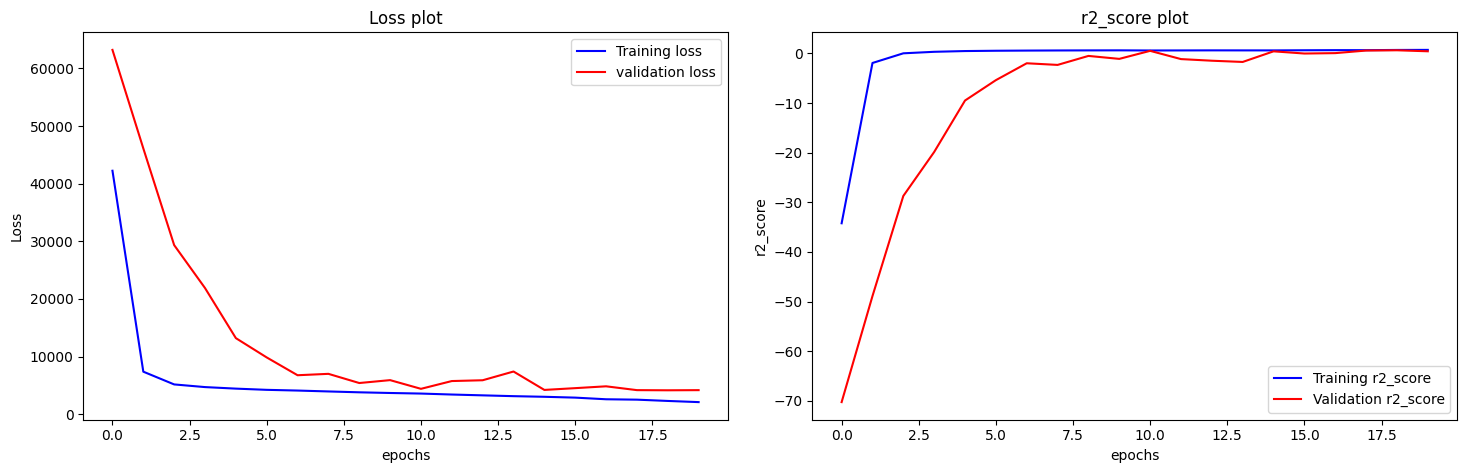

In [ ]:
acc_loss_plot(history)

### **Transfer Learning - Xavier initialization**

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    # input_shape = (300,400,3),
    input_shape = (360, 640, 3),
    include_top = False)

base_model.trainable = False

In [ ]:
# inputs = tf.keras.Input(shape = (300,400,3))
inputs = tf.keras.Input(shape = (360, 640, 3))
x = Rescaling(scale = 1./255)(inputs)
x = base_model(x, training = False)
# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# x = Dense(128, "relu")(x)
# x = Dense(64, "relu")(x)
# x = Dense(32, "relu")(x)
# outputs = tf.keras.layers.Dense(14, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(x)
outputs = tf.keras.layers.Dense(14)(x)
model = tf.keras.Model(inputs, outputs, name = "abc")

# for i in range(150, len(model.layers[2].layers)):
#   model.layers[2].layers[i].trainable = True

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = [tf.keras.metrics.R2Score()]
)

#mean square error handle outlier

In [ ]:
model.summary()

Model: "abc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 360, 640, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 360, 640, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 12, 20, 2048)      23564800  
                                                                 
 flatten (Flatten)           (None, 491520)            0         
                                                                 
 dense (Dense)               (None, 14)                6881294   
                                                                 
Total params: 30446094 (116.14 MB)
Trainable params: 6881294 (26.25 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 100, batch_size = 32)

Epoch 1/100
26/26 [==============================] - 50s 1s/step - loss: 54153.4062 - r2_score: -45.4320 - val_loss: 29301.8984 - val_r2_score: -30.6742
Epoch 2/100
26/26 [==============================] - 11s 440ms/step - loss: 19132.4863 - r2_score: -13.6506 - val_loss: 11080.4424 - val_r2_score: -7.4004
Epoch 3/100
26/26 [==============================] - 12s 448ms/step - loss: 8332.6006 - r2_score: -3.0817 - val_loss: 6361.9087 - val_r2_score: -1.3707
Epoch 4/100
26/26 [==============================] - 13s 507ms/step - loss: 5612.6050 - r2_score: -0.5132 - val_loss: 5330.1104 - val_r2_score: -0.2176
Epoch 5/100
26/26 [==============================] - 12s 482ms/step - loss: 4916.5889 - r2_score: 0.0683 - val_loss: 5013.4253 - val_r2_score: 0.0665
Epoch 6/100
26/26 [==============================] - 14s 524ms/step - loss: 4603.0732 - r2_score: 0.2808 - val_loss: 4837.7935 - val_r2_score: 0.2181
Epoch 7/100
26/26 [==============================] - 13s 516ms/step - loss: 4382.9092 - 

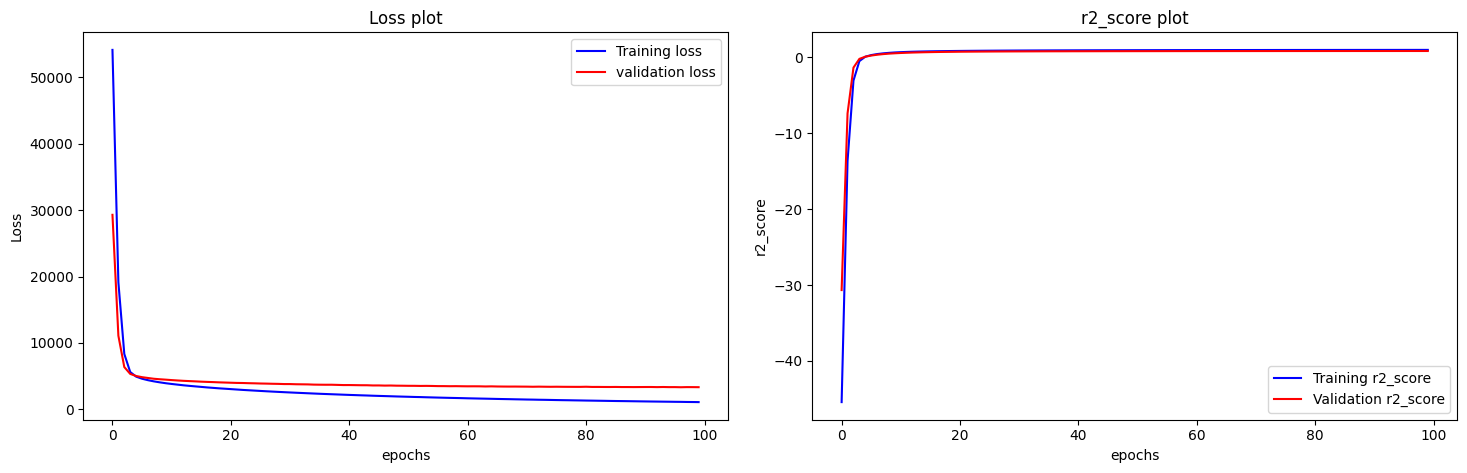

In [ ]:
# path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/acc_loss_plot.jpg"
plot_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/acc_loss_plot.jpg"
acc_loss_plot(history, path = plot_path)

In [ ]:
model.evaluate(test_matrix, test_labels)

4/4 [==============================] - 1s 285ms/step - loss: 3663.0830 - r2_score: 0.8071


[3663.0830078125, 0.807124137878418]

In [ ]:
#saving the weights of the model
weights_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/weights_with_Xavier_shortMPII.h5"
model.save_weights(weights_path)
# model.load_weights(weights_path)

In [ ]:
model.save("/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/best_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Transfer Learning - he initialization**

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape = (360, 640, 3),
    include_top = False)

base_model.trainable = False

In [ ]:
for i in range(len(base_model.layers)-50, len(base_model.layers)):
  if base_model.layers[i].__class__ == tf.keras.layers.Conv2D:
    print(f"[{i}] - {base_model.layers[i].name}")
    base_model.layers[i].kernel_initializer = tf.keras.initializers.he_uniform()
    print(base_model.layers[i].kernel_initializer)
    base_model.layers[i].trainable = True

[140] - conv4_block5_3_conv
[144] - conv4_block6_1_conv
[148] - conv4_block6_2_conv
[152] - conv4_block6_3_conv
[156] - conv5_block1_1_conv
[160] - conv5_block1_2_conv
[163] - conv5_block1_0_conv
[164] - conv5_block1_3_conv
[168] - conv5_block2_1_conv
[172] - conv5_block2_2_conv
[175] - conv5_block2_3_conv
[179] - conv5_block3_1_conv
[183] - conv5_block3_2_conv
[186] - conv5_block3_3_conv


In [ ]:
for i in range(len(base_model.layers)):
  if base_model.layers[i].trainable:
    print(f"[{i}] - {base_model.layers[i].name}")

[140] - conv4_block5_3_conv
[144] - conv4_block6_1_conv
[148] - conv4_block6_2_conv
[152] - conv4_block6_3_conv
[156] - conv5_block1_1_conv
[160] - conv5_block1_2_conv
[163] - conv5_block1_0_conv
[164] - conv5_block1_3_conv
[168] - conv5_block2_1_conv
[172] - conv5_block2_2_conv
[175] - conv5_block2_3_conv
[179] - conv5_block3_1_conv
[183] - conv5_block3_2_conv
[186] - conv5_block3_3_conv


In [ ]:
inputs = tf.keras.Input(shape = (360, 640, 3))
x = Rescaling(scale = 1./255)(inputs)
x = base_model(x, training = False)
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = Dense(128, "relu")(x)
# x = Dense(64, "relu")(x)
# x = Dense(32, "relu")(x)
# outputs = tf.keras.layers.Dense(14, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(x)
outputs = tf.keras.layers.Dense(14)(x)
model = tf.keras.Model(inputs, outputs, name = "abc")

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.01),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
model.summary()

Model: "abc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 360, 640, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 360, 640, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 12, 20, 2048)      23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 14)                1806      
                                                               

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 100, batch_size = 32)

Epoch 1/100
26/26 [==============================] - 51s 1s/step - loss: 30408.9375 - r2_score: -22.6907 - val_loss: 7413.9731 - val_r2_score: -2.1148
Epoch 2/100
26/26 [==============================] - 13s 512ms/step - loss: 7195.2085 - r2_score: -1.4030 - val_loss: 5937.4165 - val_r2_score: -0.5876
Epoch 3/100
26/26 [==============================] - 11s 435ms/step - loss: 5847.4038 - r2_score: -0.3773 - val_loss: 5720.8955 - val_r2_score: -0.2647
Epoch 4/100
26/26 [==============================] - 11s 430ms/step - loss: 5562.0342 - r2_score: -0.1457 - val_loss: 5506.6294 - val_r2_score: -0.1025
Epoch 5/100
26/26 [==============================] - 12s 478ms/step - loss: 5403.5801 - r2_score: 0.0101 - val_loss: 5378.3755 - val_r2_score: 0.0213
Epoch 6/100
26/26 [==============================] - 11s 429ms/step - loss: 5290.6987 - r2_score: 0.0818 - val_loss: 5371.6494 - val_r2_score: 0.0862
Epoch 7/100
26/26 [==============================] - 12s 473ms/step - loss: 5191.4526 - r2_sc

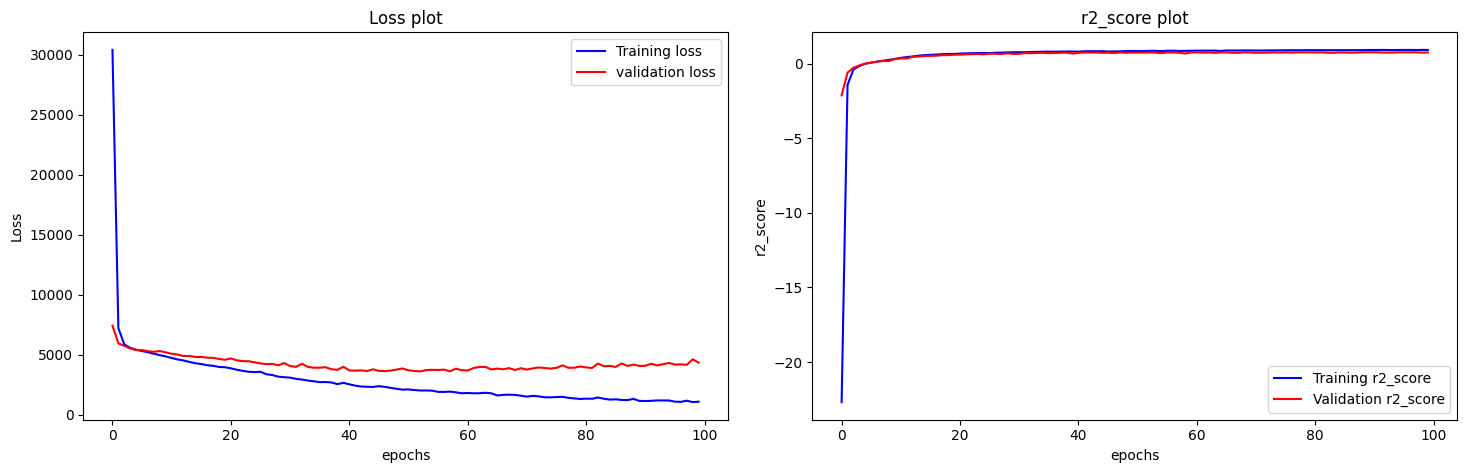

In [ ]:
# path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze_Short/acc_loss_plot.jpg"
plot_path = "/content/drive/MyDrive/MPIIFaceGaze/MPIIFaceGaze/acc_loss_plot.jpg"
acc_loss_plot(history, path = plot_path)

In [ ]:
model.evaluate(test_matrix, test_labels)

4/4 [==============================] - 1s 274ms/step - loss: 4130.0654 - r2_score: 0.7636


[4130.0654296875, 0.7636236548423767]

In [ ]:
#saving the weights of the model
weights_path = "/content/drive/MyDrive/GI4E_Dataset/Model_weights/weights_with_rescaling.h5"
model.save_weights(weights_path)
# model.load_weights(weights_path)

In [ ]:
weights_path = "/content/drive/MyDrive/GI4E_Dataset/Model_weights/weights_with_rescaling.h5"
model.load_weights(weights_path)

#test

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape = (300,400,3),
    # input_shape = (360, 640, 3),
    include_top = False)

base_model.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
inputs = tf.keras.Input(shape = (300,400,3))
# inputs = tf.keras.Input(shape = (360, 640, 3))
x = Rescaling(scale = 1./255)(inputs)
x = base_model(x, training = False)
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = Dense(128, "relu")(x)
# x = Dense(64, "relu")(x)
# x = Dense(32, "relu")(x)
outputs = tf.keras.layers.Dense(12)(x)
# outputs = tf.keras.layers.Dense(14)(x)
# outputs = tf.keras.layers.Dense(14)(x)
model = tf.keras.Model(inputs, outputs, name = "abc")

# for i in range(150, len(model.layers[2].layers)):
#   model.layers[2].layers[i].trainable = True

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = [tf.keras.metrics.R2Score()]
)

#mean square error handle outlier

In [ ]:
model.summary()

Model: "abc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 300, 400, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 10, 13, 2048)      23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                               

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 100, batch_size = 32)

Epoch 1/100
31/31 [==============================] - 28s 452ms/step - loss: 31560.7324 - r2_score: -90.3774 - val_loss: 31025.5781 - val_r2_score: -80.6532
Epoch 2/100
31/31 [==============================] - 8s 244ms/step - loss: 30219.4883 - r2_score: -86.6993 - val_loss: 29465.8047 - val_r2_score: -76.7216
Epoch 3/100
31/31 [==============================] - 7s 237ms/step - loss: 28497.5371 - r2_score: -81.9756 - val_loss: 27534.2910 - val_r2_score: -71.8469
Epoch 4/100
31/31 [==============================] - 7s 230ms/step - loss: 26422.0703 - r2_score: -76.2673 - val_loss: 25262.4961 - val_r2_score: -66.1000
Epoch 5/100
31/31 [==============================] - 8s 254ms/step - loss: 24043.5469 - r2_score: -69.7006 - val_loss: 22722.1836 - val_r2_score: -59.6451
Epoch 6/100
31/31 [==============================] - 7s 238ms/step - loss: 21441.9629 - r2_score: -62.4884 - val_loss: 20008.6504 - val_r2_score: -52.7237
Epoch 7/100
31/31 [==============================] - 8s 252ms/step - 

#after test

###### without_rescaling

In [ ]:
del model
del base_model

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape = (300,400,3),
    include_top = False)

base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape = (300,400,3))
# x = Rescaling(scale = 1./255)(inputs)
x = base_model(inputs, training = False)
# x = Flatten()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, "relu")(x)
# x = Dropout(0.3)(x)
x = Dense(256, "relu")(x)
outputs = tf.keras.layers.Dense(12)(x)
model = tf.keras.Model(inputs, outputs, name = "abc")

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
model.summary()

Model: "abc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 400, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 10, 13, 2048)      23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 12)                3084      
                                                               

In [ ]:
inputs = Rescaling(scale = 1./255)(train_matrix)

In [ ]:
history = model.fit(inputs, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 70, batch_size = 64)

Epoch 1/70
16/16 [==============================] - 58s 2s/step - loss: 25550.2988 - r2_score: -73.3142 - val_loss: 41398884.0000 - val_r2_score: -103602.7109
Epoch 2/70
16/16 [==============================] - 8s 511ms/step - loss: 3826.7253 - r2_score: -9.5173 - val_loss: 243951408.0000 - val_r2_score: -648659.9375
Epoch 3/70
16/16 [==============================] - 8s 522ms/step - loss: 1188.8611 - r2_score: -1.7606 - val_loss: 184757376.0000 - val_r2_score: -496563.1562
Epoch 4/70
16/16 [==============================] - 8s 485ms/step - loss: 793.5052 - r2_score: -0.8553 - val_loss: 189399040.0000 - val_r2_score: -498374.1562
Epoch 5/70
16/16 [==============================] - 8s 488ms/step - loss: 662.5799 - r2_score: -0.5485 - val_loss: 211048400.0000 - val_r2_score: -559501.0000
Epoch 6/70
16/16 [==============================] - 8s 502ms/step - loss: 593.1873 - r2_score: -0.3776 - val_loss: 199444144.0000 - val_r2_score: -527104.1250
Epoch 7/70
16/16 [==========================

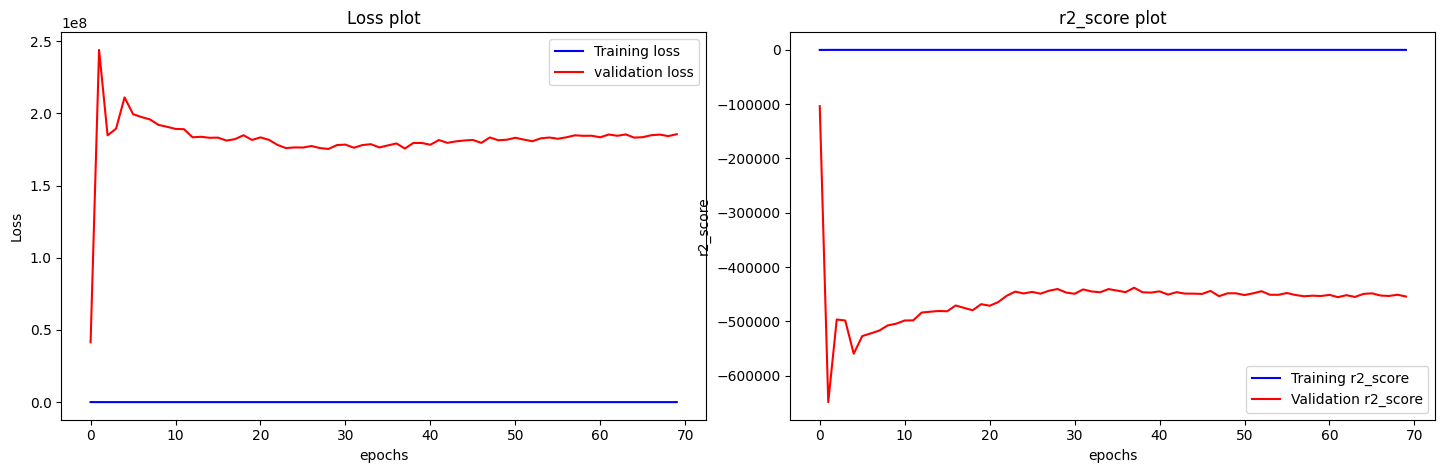

In [ ]:
acc_loss_plot(history)

In [ ]:
model.evaluate(test_matrix, test_labels)

4/4 [==============================] - 6s 222ms/step - loss: 179924480.0000 - r2_score: -559609.0625


[179924480.0, -559609.0625]

In [ ]:
#saving the weights of the model
weights_path = "/content/drive/MyDrive/GI4E_Dataset/Model_weights/weights_without_rescaling.h5"
model.save_weights(weights_path)
# model.load_weights(weights_path)

#### **Predicting Test Images**

In [ ]:
for i in range(len(test_matrix)):
  pred = model.predict(tf.expand_dims(test_matrix[i], axis = 0))
  print(f"test_matrix[{i}]: {pred[0].astype(int)}")
  show_box_MPII(test_matrix[i], (pred[0]).astype(int))
  print()

### **Predicting Real Images**

1/1 [==============================] - 2s 2s/step


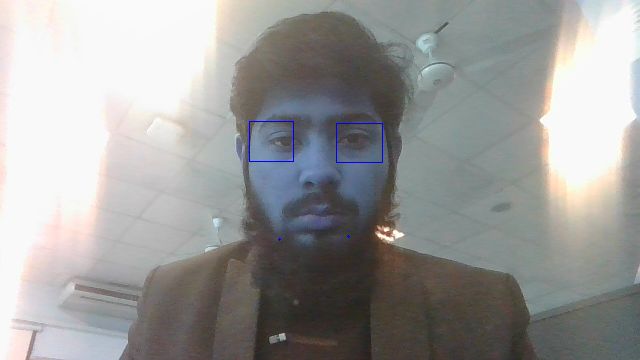

In [ ]:
img_path = "/content/WIN_20231227_11_29_29_Pro.jpg"
img = img_to_array(load_img(img_path, target_size = (360, 640)))
pred = model.predict(tf.expand_dims(img, axis = 0))
a = show_box_MPII(img, (pred[0]).astype(int))

1/1 [==============================] - 0s 28ms/step


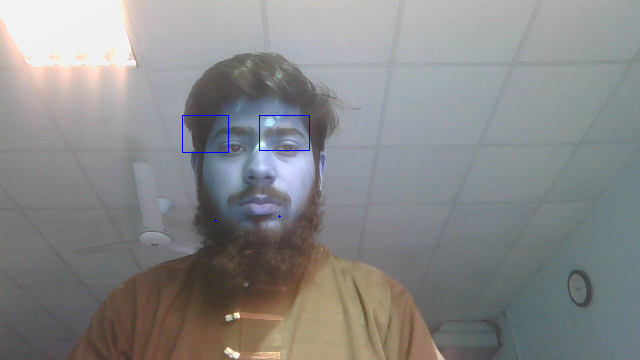

In [ ]:
img_path = "/content/WIN_20231227_13_14_27_Pro.jpg"
img = img_to_array(load_img(img_path, target_size = (360, 640)))
pred = model.predict(tf.expand_dims(img, axis = 0))
a = show_box_MPII(img, (pred[0]).astype(int))

1/1 [==============================] - 0s 79ms/step


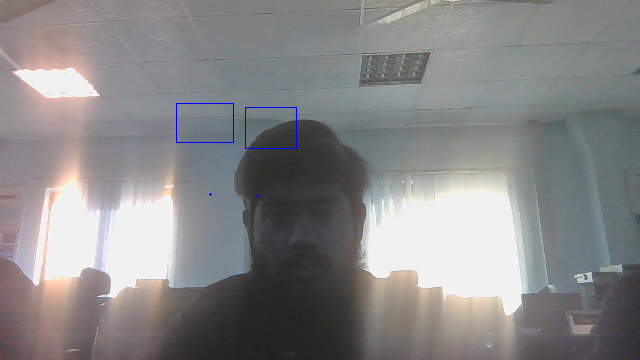

In [ ]:
img_path = "/content/WIN_20231227_13_17_42_Pro.jpg"
img = img_to_array(load_img(img_path, target_size = (360, 640)))
pred = model.predict(tf.expand_dims(img, axis = 0))
a = show_box_MPII(img, (pred[0]).astype(int))

### **Fine Tuning**

In [ ]:
model.summary()

Model: "abc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 300, 400, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 10, 13, 2048)      23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                               

In [ ]:
for i in range(150, len(model.layers[2].layers)):
  model.layers[2].layers[i].trainable = True

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.01),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
# for i in range(len(model.layers[2].layers)):
#   print(f"[{i}] - {model.layers[2].layers[i].trainable}")

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 20, batch_size = 64)

Epoch 1/20
16/16 [==============================] - 39s 2s/step - loss: 17152.2324 - r2_score: -54.5491 - val_loss: 2384.1426 - val_r2_score: -3.4424
Epoch 2/20
16/16 [==============================] - 8s 514ms/step - loss: 1952.5530 - r2_score: -3.2998 - val_loss: 1009.4879 - val_r2_score: -1.0168
Epoch 3/20
16/16 [==============================] - 8s 502ms/step - loss: 594.6761 - r2_score: -0.5989 - val_loss: 334.1510 - val_r2_score: 0.2125
Epoch 4/20
16/16 [==============================] - 8s 499ms/step - loss: 305.1335 - r2_score: 0.1851 - val_loss: 195.3940 - val_r2_score: 0.5291
Epoch 5/20
16/16 [==============================] - 8s 519ms/step - loss: 185.5020 - r2_score: 0.5329 - val_loss: 130.7133 - val_r2_score: 0.6849
Epoch 6/20
16/16 [==============================] - 8s 499ms/step - loss: 121.3351 - r2_score: 0.6960 - val_loss: 91.0815 - val_r2_score: 0.7831
Epoch 7/20
16/16 [==============================] - 8s 506ms/step - loss: 77.5916 - r2_score: 0.8060 - val_loss: 61.

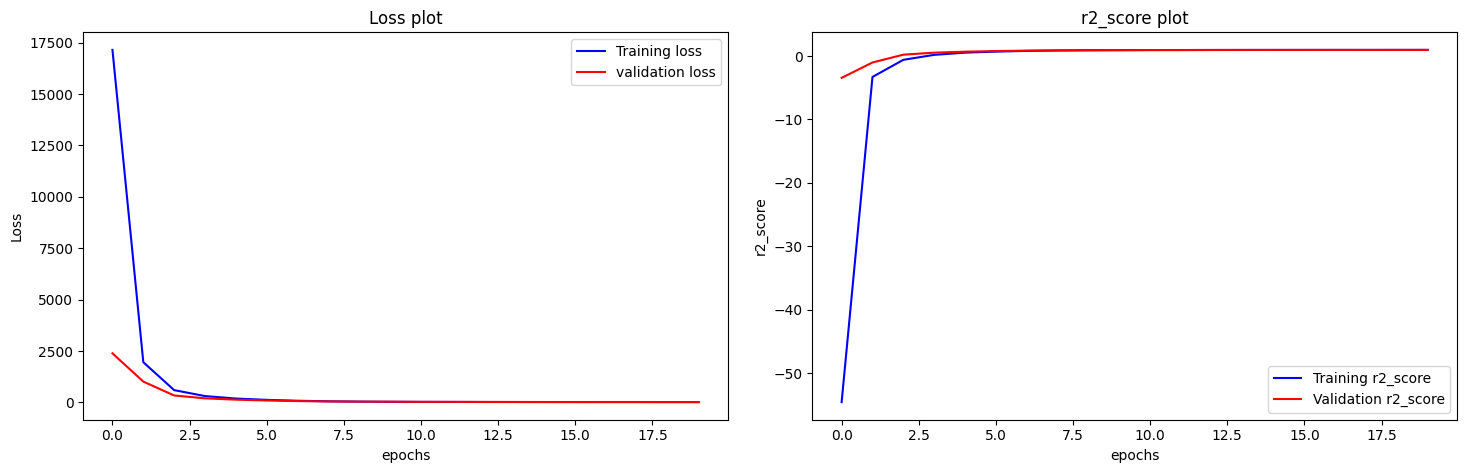

In [ ]:
acc_loss_plot(history)

In [ ]:
model.evaluate(test_matrix, test_labels)

4/4 [==============================] - 6s 210ms/step - loss: 17.8590 - r2_score: 0.9418


[17.85895347595215, 0.9418060779571533]

1/1 [==============================] - 2s 2s/step
[229 146 222 146 214 147 194 148 185 147 177 147]


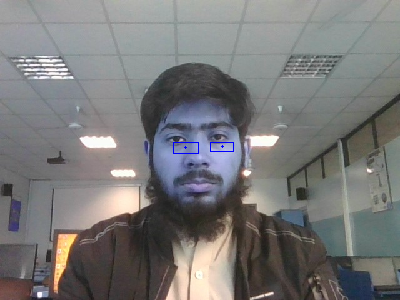

In [ ]:
img_path = "/content/WIN_20231218_15_18_24_Pro.jpg"
img = img_to_array(load_img(img_path, target_size = (300, 400)))
pred = model.predict(tf.expand_dims(img, axis = 0))
print(pred[0].astype(int))
img1 = show_box(img, (pred[0]).astype(int))

### **Full retrain**

In [ ]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape = (300,400,3),
    include_top = False)

base_model.trainable = True

In [ ]:
inputs = tf.keras.Input(shape = (300,400,3))
x = Rescaling(scale = 1./255)(inputs)
x = base_model(x, training = True)
# x = Flatten()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, "relu")(x)
# x = Dropout(0.3)(x)
x = Dense(256, "relu")(x)
outputs = tf.keras.layers.Dense(12)(x)
model = tf.keras.Model(inputs, outputs, name = "abc")

In [ ]:
for i in range(40, len(model.layers[2].layers)):
  model.layers[2].layers[i].trainable = True

In [ ]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(0.01),
    metrics = [tf.keras.metrics.R2Score()]
)

In [ ]:
history = model.fit(train_matrix, train_labels, validation_data = (validation_matrix, validation_labels), epochs = 20, batch_size = 64)

Epoch 1/20
16/16 [==============================] - 101s 3s/step - loss: 14211.6973 - r2_score: -38.7058 - val_loss: 2905.5913 - val_r2_score: -6.7002
Epoch 2/20
16/16 [==============================] - 22s 1s/step - loss: 1174.4419 - r2_score: -1.9368 - val_loss: 601.8636 - val_r2_score: -0.3359
Epoch 3/20
16/16 [==============================] - 22s 1s/step - loss: 518.3413 - r2_score: -0.1536 - val_loss: 447.5587 - val_r2_score: 0.0459
Epoch 4/20
16/16 [==============================] - 22s 1s/step - loss: 448.1651 - r2_score: 0.0314 - val_loss: 453.3483 - val_r2_score: 0.0320
Epoch 5/20
16/16 [==============================] - 22s 1s/step - loss: 439.2482 - r2_score: 0.0276 - val_loss: 413.2784 - val_r2_score: 0.1309
Epoch 6/20
16/16 [==============================] - 22s 1s/step - loss: 412.9013 - r2_score: 0.1113 - val_loss: 425.7346 - val_r2_score: 0.0989
Epoch 7/20
16/16 [==============================] - 22s 1s/step - loss: 436.5377 - r2_score: 0.0564 - val_loss: 439.9407 - va

ResourceExhaustedError: ignored